In [1]:
#!/usr/bin/env python
# coding: utf-8

get_ipython().system('chcp 1251')


PYTORCH_CUDA_ALLOC_CONF="expandable_segments:True"


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import os
import copy
import seaborn as sns

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)

print("Версия CUDA:", torch.version.cuda)


# # Abstactive Summarization

# Задача - по тексту сгенерировать выдержку из него.
# 
# Например, попробуем по новостям генерировать заголовки:


get_ipython().system('shuf -n 10 news.csv')


# Токенизируем их. Будем использовать единый словарь для текста и заголовков.


from torchtext.data import Field, Example, Dataset, BucketIterator

BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

word_field = Field(tokenize='moses', init_token=BOS_TOKEN, eos_token=EOS_TOKEN, lower=True)
fields = [('source', word_field), ('target', word_field)]



import pandas as pd
#from tqdm.auto import tqdm
from tqdm.notebook import tqdm

data = pd.read_csv('news.csv', delimiter=',')

examples = []
for _, row in tqdm(data.iterrows(), total=len(data)):
    source_text = word_field.preprocess(row.text)
    target_text = word_field.preprocess(row.title)
    examples.append(Example.fromlist([source_text, target_text], fields))


# Построим датасеты:


dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

word_field.build_vocab(train_dataset, min_freq=7)
print('Vocab size =', len(word_field.vocab))

train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(16, 32), shuffle=True, device=DEVICE, sort=False
)

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate):
        super().__init__()
        self._norm = LayerNorm(size)
        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, sublayer):
        return inputs + self._dropout(sublayer(self._norm(inputs)))

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()

        self._gamma = nn.Parameter(torch.ones(features))
        self._beta = nn.Parameter(torch.zeros(features))
        self._eps = eps

    def forward(self, inputs):
        mean = inputs.mean(-1, keepdim=True)
        std = inputs.std(-1, keepdim=True)
        return self._gamma * (inputs - mean) / (std + self._eps) + self._beta


class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, mask):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self._dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, heads_count, d_model, dropout_rate=0.1):
        super().__init__()

        assert d_model % heads_count == 0

        self._d_k = d_model // heads_count
        self._heads_count = heads_count
        self._attention = ScaledDotProductAttention(dropout_rate)
        self._attn_probs = None

        self._w_q = nn.Linear(d_model, d_model)
        self._w_k = nn.Linear(d_model, d_model)
        self._w_v = nn.Linear(d_model, d_model)
        self._w_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        query = self._w_q(query).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        key = self._w_k(key).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        value = self._w_v(value).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        x, self._attn_probs = self._attention(query, key, value, mask)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self._heads_count * self._d_k)
        x = self._w_o(x)
        return x


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        return self.w_2(self.dropout(F.relu(self.w_1(inputs))))


class EncoderBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, mask):
        outputs = self._self_attention_block(inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, mask))
        return self._feed_forward_block(outputs, self._feed_forward)


class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()

        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, d_model),
            PositionalEncoding(d_model, dropout_rate)
        )

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)

        for block in self._blocks:
            inputs = block(inputs, mask)

        return self._norm(inputs)


class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, encoder_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._encoder_attn = encoder_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        outputs = self._self_attention_block(
            inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, target_mask)
        )
        outputs = self._attention_block(
            outputs, lambda inputs: self._encoder_attn(inputs, encoder_output, encoder_output, source_mask)
        )
        return self._feed_forward_block(outputs, self._feed_forward)



class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()
        self.attn_weights = []  
        
        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, d_model),
            PositionalEncoding(d_model, dropout_rate)
        )

        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)
        self._out_layer = nn.Linear(d_model, vocab_size)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        self.attn_weights = []  
        inputs = self._emb(inputs)
        
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
            
            self.attn_weights.append(block._encoder_attn._attn_probs)
            
        return self._out_layer(self._norm(inputs))


def subsequent_mask(size):
    mask = torch.ones(size, size, device=DEVICE).triu_()
    return mask.unsqueeze(0) == 0


plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0].cpu().numpy())


class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

#modified1
'''
class EncoderDecoder(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, d_model=256, d_ff=1024,
                 blocks_count=4, heads_count=8, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.shared_emb = nn.Embedding(target_vocab_size, d_model)  # одна матрица
        self.encoder = Encoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder = Decoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder._out_layer.weight = self.shared_emb.weight  # привязываем выходной слой
        
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
'''
#modified3
from torchtext.vocab import GloVe

# подгружаем предобученные ембеддинги
glove = GloVe(name='6B', dim=300)

# создаём матрицы ембеддингов
embedding_matrix = torch.zeros(len(word_field.vocab), 300)
for i, token in enumerate(word_field.vocab.itos):
    if token in glove.stoi:
        embedding_matrix[i] = glove[token]


class EncoderDecoder(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, d_model=300, d_ff=1024,
                 blocks_count=4, heads_count=6, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.shared_emb = nn.Embedding(target_vocab_size, d_model)
        self.shared_emb.weight.data.copy_(embedding_matrix)  #подгружаем glove
        self.encoder = Encoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder = Decoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder._out_layer.weight = self.shared_emb.weight

        for p in self.parameters():
                    if p.dim() > 1:
                        nn.init.xavier_uniform_(p)
    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return self.decoder(target_inputs, encoder_output, source_mask, target_mask)



def make_mask(source_inputs, target_inputs, pad_idx):
    source_mask = (source_inputs != pad_idx).unsqueeze(-2)
    target_mask = (target_inputs != pad_idx).unsqueeze(-2)
    target_mask = target_mask & subsequent_mask(target_inputs.size(-1)).type_as(target_mask)
    return source_mask, target_mask


def convert_batch(batch, pad_idx=1):
    source_inputs, target_inputs = batch.source.transpose(0, 1), batch.target.transpose(0, 1)
    source_mask, target_mask = make_mask(source_inputs, target_inputs, pad_idx)

    return source_inputs, target_inputs, source_mask, target_mask


batch = next(iter(train_iter))

model = EncoderDecoder(source_vocab_size=len(word_field.vocab),
                  target_vocab_size=len(word_field.vocab)).to(DEVICE)

out = model(*convert_batch(batch))

out.shape, len(word_field.vocab)

class NoamOpt(object):
    def __init__(self, model_size, factor=2, warmup=4000, optimizer=None):
        if optimizer is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))


# Идея в том, чтобы повышать learning rate в течении первых warmup шагов линейно, а затем понижать его по сложной формуле


opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])


tqdm.get_lock().locks = []


def do_epoch(model, criterion, data_iter, optimizer=None, name=None):
    epoch_loss = 0

    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)
                logits = model.forward(source_inputs, target_inputs[:, :-1], source_mask, target_mask[:, :-1, :-1])

                logits = logits.contiguous().view(-1, logits.shape[-1])
                target = target_inputs[:, 1:].contiguous().view(-1)
                loss = criterion(logits, target)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(name, loss.item(),
                                                                                         math.exp(loss.item())))

            progress_bar.set_description('{:>5s} Loss = {:.5f}, PPX = {:.2f}'.format(
                name, epoch_loss / batches_count, math.exp(epoch_loss / batches_count))
            )
            progress_bar.refresh()

    return epoch_loss / batches_count


def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None, save_dir='checkpoints'):
    best_val_loss = float('inf')
    training_history = {'train_loss': [], 'val_loss': []}
    
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    log_file = open('logs/training_log.txt', 'w', encoding='utf-8')

    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + 'Train:')
        training_history['train_loss'].append(train_loss)

        log_message = f'Epoch {epoch + 1}: Train loss: {train_loss:.4f}'

        if val_iter is not None:
            val_loss = do_epoch(model, criterion, val_iter, None, name_prefix + '  Val:')
            training_history['val_loss'].append(val_loss)
            log_message += f', Val loss: {val_loss:.4f}'

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
                print(f"New best model saved with val loss: {best_val_loss:.4f}")

        print(log_message)
        log_file.write(log_message + '\n')
        log_file.flush()

        if epoch % 5 == 0 or epoch == epochs_count - 1:
            checkpoint_path = os.path.join(save_dir, f'model_epoch_{epoch + 1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.optimizer.state_dict(),
                'loss': train_loss,
                'training_history': training_history
            }, checkpoint_path)
            print(f'Saved checkpoint to {checkpoint_path}')

    log_file.close()

    plt.figure(figsize=(10, 5))
    plt.plot(training_history['train_loss'], label='Training Loss')
    if training_history['val_loss']:
        plt.plot(training_history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('logs/training_history.png')
    plt.close()

    torch.save(model.state_dict(), os.path.join(save_dir, 'final_model.pth'))
    print("Final model saved")

    return training_history

#exchange лосс на LabelSmoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.1):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction='batchmean')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size

    def forward(self, x, target):
        assert x.shape[1] == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        return self.criterion(x, true_dist.detach())


model = EncoderDecoder(source_vocab_size=len(word_field.vocab), target_vocab_size=len(word_field.vocab)).to(DEVICE)

pad_idx = word_field.vocab.stoi['<pad>']
#added label_smoothing
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1).to(DEVICE)

optimizer = NoamOpt(model.d_model)

fit(model, criterion, optimizer, train_iter, epochs_count=30, val_iter=test_iter)

Текущая кодовая страница: 1251
Версия CUDA: 12.1
124299,"Р’ СЃРµС‚Рё РїРѕСЏРІРёР»РёСЃСЊ РєР°РґСЂС‹ СЃ РјРµСЃС‚Р° РІР·СЂС‹РІР° Р°РІС‚РѕР±СѓСЃР° РІ Р�РµСЂСѓСЃР°Р»РёРјРµ. РџРµСЂРІРѕРЅР°С‡Р°Р»СЊРЅРѕ СЃРѕРѕР±С‰Р°Р»РѕСЃСЊ Рѕ РІРѕР·РјРѕР¶РЅРѕР№ С‚РµС…РЅРёС‡РµСЃРєРѕР№ РЅРµРїРѕР»Р°РґРєРµ, РЅРѕ РїРѕС‚РѕРј СЃР»РµРґРѕРІР°С‚РµР»Рё РѕР±РЅР°СЂСѓР¶РёР»Рё РґРµС‚Р°Р»Рё РЅРµР±РѕР»СЊС€РѕРіРѕ РІР·СЂС‹РІРЅРѕРіРѕ СѓСЃС‚СЂРѕР№СЃС‚РІР°. Р’ СЂРµР·СѓР»СЊС‚Р°С‚Рµ РїСЂРѕРёСЃС€РµСЃС‚РІРёСЏ РЅРёРєС‚Рѕ РЅРµ РїРѕРіРёР±, РЅРѕ 16 С‡РµР»РѕРІРµРє РїРѕР»СѓС‡РёР»Рё СЂР°РЅРµРЅРёСЏ СЂР°Р·Р»РёС‡РЅРѕР№ СЃС‚РµРїРµРЅРё С‚СЏР¶РµСЃС‚Рё.",Р’ СЃРµС‚Рё РїРѕСЏРІРёР»РёСЃСЊ РєР°РґСЂС‹ СЃВ РјРµСЃС‚Р° РІР·СЂС‹РІР° РІВ Р�РµСЂСѓСЃР°Р»РёРјРµ
487195,"РќР° РњР°РґР°РіР°СЃРєР°СЂРµ РїСЂРёРіРѕРІРѕСЂРµРЅ Рє С‚СЋСЂРµРјРЅРѕРјСѓ Р·Р°РєР»СЋС‡РµРЅРёСЋ Р¶РёС‚РµР»СЊ РљСЂР°СЃРЅРѕСЏСЂСЃРєР°, РєРѕС‚РѕСЂРѕРіРѕ РјРµСЃС‚РЅС‹Рµ РІР»Р°СЃС‚Рё РѕР±РІРёРЅРёР»Рё РІ Р±СЂР°РєРѕРЅСЊРµСЂСЃС‚РІРµ. РџРѕ РґР°РЅРЅС‹Рј ""РђРІС‚РѕСЂР°РґРёРѕ-РљСЂР°СЃРЅРѕСЏСЂСЃРє"", Р’Р»Р°РґРёРјР

  0%|          | 0/74278 [00:00<?, ?it/s]

Train size = 63136
Test size = 11142
Vocab size = 55877


C:\Users\artru\anaconda3\Lib\site-packages\torchtext\vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim = torch.load(pa

  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 7.1312
Epoch 1: Train loss: 7.7745, Val loss: 7.1312
Saved checkpoint to checkpoints\model_epoch_1.pth


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 6.7157
Epoch 2: Train loss: 6.9916, Val loss: 6.7157


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 6.4956
Epoch 3: Train loss: 6.7977, Val loss: 6.4956


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 6.2880
Epoch 4: Train loss: 6.5866, Val loss: 6.2880


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 6.0679
Epoch 5: Train loss: 6.3677, Val loss: 6.0679


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.9151
Epoch 6: Train loss: 6.1635, Val loss: 5.9151
Saved checkpoint to checkpoints\model_epoch_6.pth


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.7529
Epoch 7: Train loss: 6.0091, Val loss: 5.7529


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.6274
Epoch 8: Train loss: 5.8586, Val loss: 5.6274


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.4918
Epoch 9: Train loss: 5.7063, Val loss: 5.4918


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.4077
Epoch 10: Train loss: 5.5733, Val loss: 5.4077


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.3284
Epoch 11: Train loss: 5.4626, Val loss: 5.3284
Saved checkpoint to checkpoints\model_epoch_11.pth


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.2464
Epoch 12: Train loss: 5.3648, Val loss: 5.2464


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.1853
Epoch 13: Train loss: 5.2760, Val loss: 5.1853


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.0810
Epoch 14: Train loss: 5.1971, Val loss: 5.0810


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 5.0396
Epoch 15: Train loss: 5.1174, Val loss: 5.0396


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.9930
Epoch 16: Train loss: 5.0820, Val loss: 4.9930
Saved checkpoint to checkpoints\model_epoch_16.pth


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.9308
Epoch 17: Train loss: 5.0268, Val loss: 4.9308


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.8754
Epoch 18: Train loss: 4.9584, Val loss: 4.8754


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.8392
Epoch 19: Train loss: 4.9110, Val loss: 4.8392


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.8033
Epoch 20: Train loss: 4.8763, Val loss: 4.8033


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.7569
Epoch 21: Train loss: 4.8225, Val loss: 4.7569
Saved checkpoint to checkpoints\model_epoch_21.pth


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.6946
Epoch 22: Train loss: 4.7758, Val loss: 4.6946


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.6515
Epoch 23: Train loss: 4.7142, Val loss: 4.6515


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.5830
Epoch 24: Train loss: 4.6412, Val loss: 4.5830


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.5636
Epoch 25: Train loss: 4.5779, Val loss: 4.5636


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.5192
Epoch 26: Train loss: 4.5158, Val loss: 4.5192
Saved checkpoint to checkpoints\model_epoch_26.pth


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.4996
Epoch 27: Train loss: 4.4712, Val loss: 4.4996


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.4617
Epoch 28: Train loss: 4.4354, Val loss: 4.4617


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.4389
Epoch 29: Train loss: 4.3970, Val loss: 4.4389


  0%|          | 0/3946 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

New best model saved with val loss: 4.4017
Epoch 30: Train loss: 4.3550, Val loss: 4.4017
Saved checkpoint to checkpoints\model_epoch_30.pth
Final model saved


{'train_loss': [7.774544211975886,
  6.991609425696998,
  6.797736971014596,
  6.58659703503148,
  6.367683008366047,
  6.1634632447499405,
  6.0091367903785295,
  5.858630171054157,
  5.7062679999864345,
  5.573349030442003,
  5.462618869630685,
  5.364774596189643,
  5.276046295789554,
  5.1971205395608155,
  5.117365224918495,
  5.082042414949923,
  5.026802807789554,
  4.958417979944676,
  4.91100752311374,
  4.876342397018912,
  4.8225165343925065,
  4.775808711554638,
  4.714174386213953,
  4.641153506983734,
  4.577879939777744,
  4.515795474842727,
  4.471234196463757,
  4.435420535629435,
  4.396960904074996,
  4.354967524723782],
 'val_loss': [7.131208671198192,
  6.715712701693647,
  6.49560056374886,
  6.288011242120518,
  6.0678780454619226,
  5.9150934041741925,
  5.752892263297706,
  5.627379556781583,
  5.4917541697920225,
  5.4076771216952695,
  5.328426261344407,
  5.246378986063522,
  5.185338999958639,
  5.080970224473401,
  5.039645036517037,
  4.993026297550147,
 

In [118]:
class EncoderBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, mask):
        outputs = self._self_attention_block(inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, mask))
        return self._feed_forward_block(outputs, self._feed_forward)

In [120]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()

        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, d_model),
            PositionalEncoding(d_model, dropout_rate)
        )

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)

        for block in self._blocks:
            inputs = block(inputs, mask)

        return self._norm(inputs)

In [122]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, encoder_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._encoder_attn = encoder_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        outputs = self._self_attention_block(
            inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, target_mask)
        )
        outputs = self._attention_block(
            outputs, lambda inputs: self._encoder_attn(inputs, encoder_output, encoder_output, source_mask)
        )
        return self._feed_forward_block(outputs, self._feed_forward)
        
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate):
        super().__init__()

        self._emb = nn.Sequential(
            nn.Embedding(vocab_size, d_model),
            PositionalEncoding(d_model, dropout_rate)
        )

        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)
        self._out_layer = nn.Linear(d_model, vocab_size)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        inputs = self._emb(inputs)
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
        return self._out_layer(self._norm(inputs))

class EncoderDecoder(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, d_model=300, d_ff=1024,
                 blocks_count=4, heads_count=6, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.shared_emb = nn.Embedding(target_vocab_size, d_model)
        self.shared_emb.weight.data.copy_(embedding_matrix)  #подгружаем glove
        self.encoder = Encoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder = Decoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate)
        self.decoder._out_layer.weight = self.shared_emb.weight

        for p in self.parameters():
                    if p.dim() > 1:
                        nn.init.xavier_uniform_(p)
    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return self.decoder(target_inputs, encoder_output, source_mask, target_mask)

Одна из ранних моделей на следующей ячейке выдала вот это:
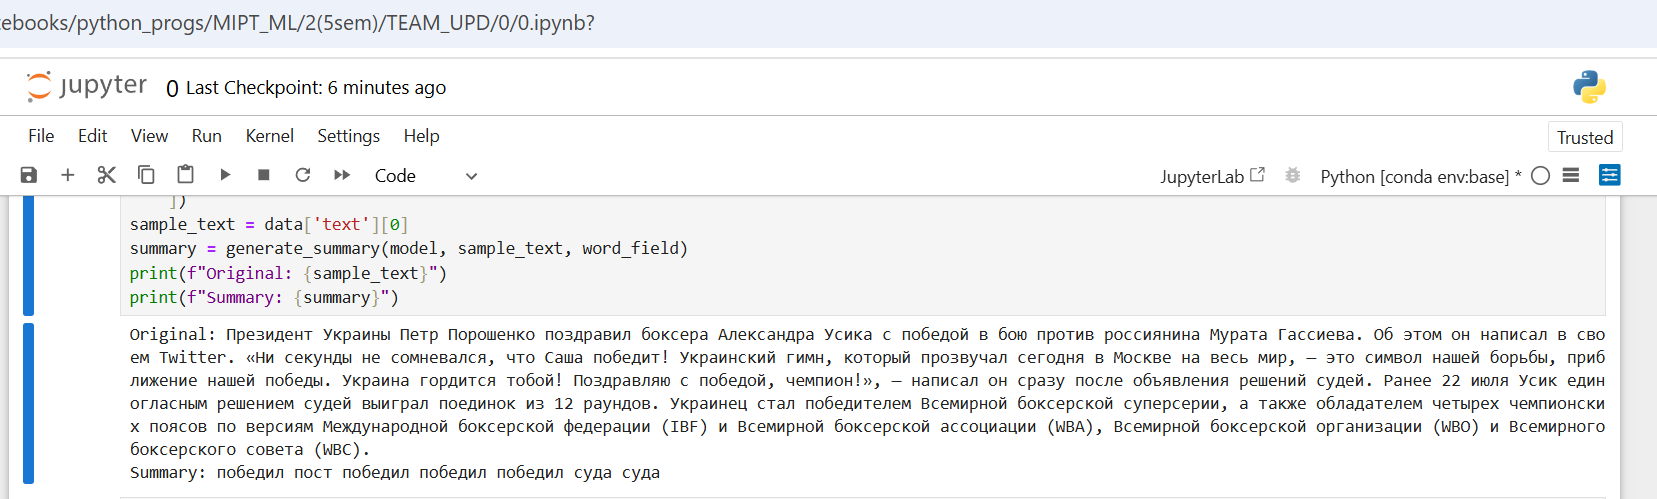

In [3]:
from rouge_score import rouge_scorer
def generate_summary(model, text, word_field, max_len=50, beam_size=5, temperature=0.5):
    model.eval()
    tokens = word_field.preprocess(text)
    src = torch.tensor([
        word_field.vocab.stoi[t] if t in word_field.vocab.stoi 
        else word_field.vocab.stoi['<unk>'] 
        for t in tokens
    ], device=DEVICE).unsqueeze(0)
    
    src_mask = (src != word_field.vocab.stoi['<pad>']).unsqueeze(-2)
    
    beams = [([word_field.vocab.stoi['<s>']], 0)]
    
    for _ in range(max_len):
        new_beams = []
        for seq, score in beams:
            if seq[-1] == word_field.vocab.stoi['</s>']:
                new_beams.append((seq, score))
                continue
                
            tgt = torch.tensor(seq, device=DEVICE).unsqueeze(0)
            tgt_mask = subsequent_mask(tgt.size(1)).to(DEVICE)
            
            with torch.no_grad():
                out = model(src, tgt, src_mask, tgt_mask)
                logits = out[:, -1, :] / temperature
                probs = F.softmax(logits, dim=-1)
            
            top_probs, top_indices = torch.topk(probs, beam_size)
            for i in range(beam_size):
                new_seq = seq + [top_indices[0, i].item()]
                if len(new_seq) > 1 and new_seq[-1] == new_seq[-2]:
                    new_score = score + (torch.log(top_probs[0, i]) - 1.0).item()
                else:
                    new_score = score + torch.log(top_probs[0, i]).item()
                new_beams.append((new_seq, new_score))
        
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        
        if all(seq[-1] == word_field.vocab.stoi['</s>'] for seq, _ in beams):
            break
    
    best_seq = beams[0][0]
    return ' '.join([
        word_field.vocab.itos[i] 
        for i in best_seq[1:-1] 
        if i not in {word_field.vocab.stoi['<unk>'], word_field.vocab.stoi['<pad>']}
    ])
sample_text = data['text'][0]
summary = generate_summary(model, sample_text, word_field)
print(f"Original: {sample_text}")
print(f"Summary: {summary}")

def evaluate_rouge_fast(model, dataset, word_field, max_len=50, beam_size=5, sample_size=None):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    # ограничиваем выборку для теста
    dataset_sample = dataset[:sample_size] if sample_size else dataset
    
    for i, example in enumerate(dataset_sample):
        hyp_summary = generate_summary(
            model, 
            ' '.join(example.source), 
            word_field,
            max_len=max_len,
            beam_size=beam_size
        )
        
        ref_summary = ' '.join([t for t in example.target if t not in ['<s>', '</s>', '<pad>']])
        
        # вычисляем метрику ROUGE
        scores = scorer.score(ref_summary, hyp_summary)
        
        for key in rouge_scores:
            rouge_scores[key].append(scores[key].fmeasure)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i+1}/{len(dataset_sample)} examples")
    
    # усредняем
    return {
        key: np.mean(values) 
        for key, values in rouge_scores.items()
    }

Original: Президент Украины Петр Порошенко поздравил боксера Александра Усика с победой в бою против россиянина Мурата Гассиева. Об этом он написал в своем Twitter. «Ни секунды не сомневался, что Саша победит! Украинский гимн, который прозвучал сегодня в Москве на весь мир, — это символ нашей борьбы, приближение нашей победы. Украина гордится тобой! Поздравляю с победой, чемпион!», — написал он сразу после объявления решений судей. Ранее 22 июля Усик единогласным решением судей выиграл поединок из 12 раундов. Украинец стал победителем Всемирной боксерской суперсерии, а также обладателем четырех чемпионских поясов по версиям Международной боксерской федерации (IBF) и Всемирной боксерской ассоциации (WBA), Всемирной боксерской организации (WBO) и Всемирного боксерского совета (WBC).
Summary: москвы москвы москвы года подряд ранены подряд


In [15]:
#rouge_scores = evaluate_rouge_fast(model, test_dataset, word_field)
#print("ROUGE Scores:", rouge_scores)

<>:186: SyntaxWarning: invalid escape sequence '\d'
<>:186: SyntaxWarning: invalid escape sequence '\d'
C:\Users\artru\AppData\Local\Temp\ipykernel_23308\3755594918.py:186: SyntaxWarning: invalid escape sequence '\d'
  r.system_filename_pattern = 'hyp.(\d+).txt'


Original: Президент Украины Петр Порошенко поздравил боксера Александра Усика с победой в бою против россиянина Мурата Гассиева. Об этом он написал в своем Twitter. «Ни секунды не сомневался, что Саша победит! Украинский гимн, который прозвучал сегодня в Москве на весь мир, — это символ нашей борьбы, приближение нашей победы. Украина гордится тобой! Поздравляю с победой, чемпион!», — написал он сразу после объявления решений судей. Ранее 22 июля Усик единогласным решением судей выиграл поединок из 12 раундов. Украинец стал победителем Всемирной боксерской суперсерии, а также обладателем четырех чемпионских поясов по версиям Международной боксерской федерации (IBF) и Всемирной боксерской ассоциации (WBA), Всемирной боксерской организации (WBO) и Всемирного боксерского совета (WBC).
Summary: на на на стадионе на новом арбате по
Processed 10/11142 examples
Processed 20/11142 examples
Processed 30/11142 examples
Processed 40/11142 examples
Processed 50/11142 examples
Processed 60/11142 exa

C:\Users\artru\AppData\Local\Temp\ipykernel_23308\3755594918.py:186: SyntaxWarning: invalid escape sequence '\d'
  r.system_filename_pattern = 'hyp.(\d+).txt'


TypeError: evaluate_rouge_fast() takes 2 positional arguments but 3 were given

In [5]:
print("\nПример генерации:")
rouge_scores = evaluate_rouge_fast(model, test_dataset[:30], word_field)
print(rouge_scores)
for idx, sample in enumerate(test_dataset[:30]):
    hyp = generate_summary(model, ' '.join(sample["source"]), word_field)
    print(f"Пример {idx+1}:")
    print(f"Исходный текст: {' '.join(sample['source'])}")
    print(f"Референс: {' '.join([t for t in sample['target'] if t not in ['<s>','</s>']])}")
    print(f"Гипотеза: {hyp}\n")


Пример генерации:
Processed 10/30 examples
Processed 20/30 examples
Processed 30/30 examples
{'rouge1': 0.02666666666666667, 'rouge2': 0.02222222222222222, 'rougeL': 0.02666666666666667}


TypeError: 'Example' object is not subscriptable

next 4 ячейки = actual

In [21]:
def generate_summary(model, text, word_field, max_len=50, beam_size=5, temperature=0.5):
    model.eval()
    if isinstance(text, list):
        text = ' '.join(text)
    
    tokens = word_field.preprocess(text)
    src = torch.tensor([
        word_field.vocab.stoi[t] if t in word_field.vocab.stoi 
        else word_field.vocab.stoi['<unk>'] 
        for t in tokens
    ], device=DEVICE).unsqueeze(0)
    
    src_mask = (src != word_field.vocab.stoi['<pad>']).unsqueeze(-2)
    
    beams = [([word_field.vocab.stoi['<s>']], 0)]
    
    for _ in range(max_len):
        new_beams = []
        for seq, score in beams:
            if seq[-1] == word_field.vocab.stoi['</s>']:
                new_beams.append((seq, score))
                continue
                
            tgt = torch.tensor(seq, device=DEVICE).unsqueeze(0)
            tgt_mask = subsequent_mask(tgt.size(1)).to(DEVICE)
            
            with torch.no_grad():
                out = model(src, tgt, src_mask, tgt_mask)
                logits = out[:, -1, :] / temperature
                probs = F.softmax(logits, dim=-1)
            
            top_probs, top_indices = torch.topk(probs, beam_size)
            for i in range(beam_size):
                new_seq = seq + [top_indices[0, i].item()]
                new_score = score + torch.log(top_probs[0, i]).item()
                new_beams.append((new_seq, new_score))
        
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        
        if all(seq[-1] == word_field.vocab.stoi['</s>'] for seq, _ in beams):
            break
    
    best_seq = beams[0][0]
    return ' '.join([
        word_field.vocab.itos[i] 
        for i in best_seq[1:-1] 
        if i not in {word_field.vocab.stoi['<unk>'], word_field.vocab.stoi['<pad>']}
    ])

In [23]:
def demonstrate_examples(model, test_dataset, custom_examples, word_field):
    print("\nTest Examples:")
    for i, example in enumerate(test_dataset.examples[:5]):
        source_text = ' '.join(example.source)
        target_text = ' '.join(example.target)
        generated = generate_summary(model, example.source, word_field)
        
        print(f"\nExample {i+1}:")
        print(f"Source: {source_text}")
        print(f"Target: {target_text}")
        print(f"Generated: {generated}")
        
        # attention - для каждого!
        visualize_attention(model, source_text, word_field, f'attention_test_{i+1}.png')
    
    print("\nCustom Examples:")
    for i, text in enumerate(custom_examples):
        generated = generate_summary(model, text, word_field)
        print(f"\nCustom Example {i+1}:")
        print(f"Source: {text}")
        print(f"Generated: {generated}")
        
        visualize_attention(model, text, word_field, f'attention_custom_{i+1}.png')

In [25]:
def visualize_attention(model, text, word_field, save_path=None):
    model.eval()
    tokens = word_field.preprocess(text)
    source = torch.tensor([
        word_field.vocab.stoi[t] if t in word_field.vocab.stoi 
        else word_field.vocab.stoi['<unk>'] 
        for t in tokens
    ], device=DEVICE).unsqueeze(0)
    
    source_mask = (source != word_field.vocab.stoi['<pad>']).unsqueeze(-2)
    
    with torch.no_grad():
        summary = generate_summary(model, text, word_field)
        summary_tokens = word_field.preprocess(summary)
        
        if hasattr(model.decoder, 'attn_weights') and model.decoder.attn_weights:
            attn_weights = model.decoder.attn_weights[-1][0].mean(dim=0)
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(attn_weights.cpu().numpy(),
                       xticklabels=tokens,
                       yticklabels=summary_tokens,
                       cmap='viridis')
            plt.title('Attention Weights Visualization')
            plt.xlabel('Source Text')
            plt.ylabel('Generated Summary')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            
            if save_path:
                plt.savefig(save_path, bbox_inches='tight')
            plt.show()
            plt.close()

In [38]:
def evaluate_complete_model(model, test_dataset, word_field):
    print("Calculating ROUGE metrics...")
    rouge_scores = evaluate_rouge_fast(model, test_dataset[:1000], word_field)
    print("ROUGE Scores:", rouge_scores)
    
    custom_examples = [
        "В результате масштабного исследования ученые обнаружили новый вид динозавров в Аргентине.",
        "Компания SpaceX успешно запустила новую партию спутников Starlink на орбиту Земли.",
        "Исследователи разработали новый метод очистки океана от пластикового мусора.",
        "В центре Москвы открылась крупнейшая выставка современного искусства.",
        "Ученые создали новый тип искусственного интеллекта."
    ]
    
    demonstrate_examples(model, test_dataset, custom_examples, word_field)
    
    torch.save(model.state_dict(), 'transformer_summarizer.pt')
    
    with open('test_predictions.txt', 'w', encoding='utf-8') as f:
        for i, example in enumerate(test_dataset.examples[:10]):
            source = ' '.join(example.source)
            target = ' '.join(example.target)
            generated = generate_summary(model, source, word_field)
            
            f.write(f"Example {i+1}:\n")
            f.write(f"Source: {source}\n")
            f.write(f"Target: {target}\n")
            f.write(f"Generated: {generated}\n")
            f.write('-' * 80 + '\n')

In [11]:
rouge_scores = evaluate_rouge_fast(model, test_dataset[:100], word_field)
print(rouge_scores)

Processed 10/100 examples
Processed 20/100 examples
Processed 30/100 examples
Processed 40/100 examples
Processed 50/100 examples
Processed 60/100 examples
Processed 70/100 examples
Processed 80/100 examples
Processed 90/100 examples
Processed 100/100 examples
{'rouge1': 0.016, 'rouge2': 0.013333333333333332, 'rougeL': 0.016}


In [13]:
def demonstrate_summarization_examples(model, test_dataset, word_field, num_examples=5):
    model.eval()
    examples = []
    
    with torch.no_grad():
        for i in range(num_examples):
            example = test_dataset.examples[i]
            source_text = ' '.join(example.source)
            target_text = ' '.join(example.target)
            
            generated_summary = generate_summary(model, source_text, word_field)
            
            examples.append({
                'source': source_text,
                'target': target_text,
                'generated': generated_summary
            })
    
    return examples

custom_examples = [
    "В результате масштабного исследования ученые обнаружили новый вид динозавров в Аргентине. Окаменелости, найденные в провинции Неукен, принадлежат ранее неизвестному виду травоядных динозавров, живших около 90 миллионов лет назад.",
    "Компания SpaceX успешно запустила новую партию спутников Starlink на орбиту Земли. Запуск был осуществлен с помощью ракеты-носителя Falcon 9 с космодрома на мысе Канаверал.",
    "Исследователи разработали новый метод очистки океана от пластикового мусора. Технология использует специальные бактерии, способные разлагать пластик на безвредные компоненты.",
    "В центре Москвы открылась крупнейшая выставка современного искусства. Экспозиция включает работы более 100 художников из 25 стран мира.",
    "Ученые создали новый тип искусственного интеллекта, способный предсказывать землетрясения за несколько дней до их возникновения. Система использует данные сейсмических датчиков и машинное обучение."
]

def add_custom_examples_to_dataset(custom_examples, word_field):
    examples = []
    for text in custom_examples:
        source_text = word_field.preprocess(text)
        target_text = word_field.preprocess(text.split('.')[0]) 
        examples.append(Example.fromlist([source_text, target_text], fields))
    return examples

In [14]:
def visualize_attention(model, text, word_field, save_path=None):
    model.eval()
    with torch.no_grad():
        tokens = word_field.preprocess(text)
        source = torch.tensor([word_field.vocab.stoi[t] for t in tokens]).unsqueeze(0).to(DEVICE)
        source_mask = (source != word_field.vocab.stoi['<pad>']).unsqueeze(-2)
        
        summary = generate_summary(model, text, word_field)
        summary_tokens = summary.split()
        
        if hasattr(model.decoder, 'attn_weights') and model.decoder.attn_weights:
            attn_weights = model.decoder.attn_weights[-1][0]  # берем веса с последнего
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(attn_weights.cpu().numpy(),
                       xticklabels=tokens,
                       yticklabels=summary_tokens,
                       cmap='viridis')
            plt.title('Attention Weights Visualization')
            plt.xlabel('Source Text')
            plt.ylabel('Generated Summary')
            
            if save_path:
                plt.savefig(save_path)
            plt.show()
        else:
            print("No attention weights available. Make sure the model is properly storing attention weights.")

In [15]:
visualize_attention(model, data['text'][0], word_field, "viz_att1")

ValueError: Must pass 2-d input. shape=(6, 9, 134)

In [ ]:
def visualize_attention_weights(model, text, word_field, save_path=None):
    model.eval()
    with torch.no_grad():
        tokens = word_field.preprocess(text)
        token_ids = [word_field.vocab.stoi[token] for token in tokens]
        source = torch.LongTensor([token_ids]).to(DEVICE)
        source_mask = (source != word_field.vocab.stoi[word_field.pad_token]).unsqueeze(-2)
        
        batch_size = 1
        src_len = len(tokens)
        attention_weights = []
        
        def hook_fn(module, input, output):
            attention_weights.append(output[1].detach().cpu())
        
        hooks = []
        for layer in model.encoder.layers:
            hook = layer.self_attn.register_forward_hook(hook_fn)
            hooks.append(hook)
        
        model.encoder(source, source_mask)
        
        for hook in hooks:
            hook.remove()
        
        num_layers = len(attention_weights)
        num_heads = attention_weights[0].size(1)
        
        for layer_idx in range(num_layers):
            layer_attention = attention_weights[layer_idx].squeeze(0)
            
            plt.figure(figsize=(20, num_heads * 4))
            for head_idx in range(num_heads):
                plt.subplot(num_heads, 1, head_idx + 1)
                sns.heatmap(layer_attention[head_idx].numpy(),
                           xticklabels=tokens,
                           yticklabels=tokens,
                           cmap='viridis')
                plt.title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
            
            if save_path:
                plt.savefig(f'{save_path}_layer_{layer_idx + 1}.png')
            plt.close()

In [ ]:
visualize_attention_weights(model, data['text'][0], word_field, "viz_att2")

In [68]:
def make_model(src_vocab_size, tgt_vocab_size, d_model=300, d_ff=1024, 
               blocks_count=4, heads_count=6, dropout_rate=0.1):
    model = EncoderDecoder(
        source_vocab_size=src_vocab_size,
        target_vocab_size=tgt_vocab_size,
        d_model=d_model,
        d_ff=d_ff,
        blocks_count=blocks_count,
        heads_count=heads_count,
        dropout_rate=dropout_rate
    )
    return model.to(DEVICE)

"""class LabelSmoothingLoss(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.shape[1] == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2)) 
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())
"""
class LabelSmoothingLoss(nn.Module):
    def __init__(self, label_smoothing, tgt_vocab_size, ignore_index=-100):
        assert 0.0 < label_smoothing <= 1.0
        self.ignore_index = ignore_index
        super(LabelSmoothingLoss, self).__init__()

        smoothing_value = label_smoothing / (tgt_vocab_size - 2)
        one_hot = torch.full((tgt_vocab_size,), smoothing_value)
        one_hot[self.ignore_index] = 0
        self.register_buffer('one_hot', one_hot.unsqueeze(0))

        self.confidence = 1.0 - label_smoothing

    def forward(self, output, target):
        model_prob = self.one_hot.repeat(target.size(0), 1)
        model_prob.scatter_(1, target.unsqueeze(1), self.confidence)
        model_prob.masked_fill_((target == self.ignore_index).unsqueeze(1), 0)

        return F.kl_div(output, model_prob, reduction='sum')

In [81]:
def train_model(epochs=30):

    model = make_model(
        len(word_field.vocab), len(word_field.vocab),
        d_model=300,
        d_ff=1024,
        blocks_count=4,
        heads_count=6,
        dropout_rate=0.1
    )
    
    criterion = LabelSmoothingLoss(
        label_smoothing=0.2,
        tgt_vocab_size=len(word_field.vocab),
        ignore_index=word_field.vocab.stoi['<pad>']
    ).to(DEVICE)
    
    optimizer = NoamOpt(model.d_model, 1, 4000,
                       torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    

    os.makedirs('checkpoints', exist_ok=True)
    

    os.makedirs('logs', exist_ok=True)
    log_file = open('logs/training_log.txt', 'w', encoding='utf-8')
    
    best_val_loss = float('inf')
    training_history = {'train_loss': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_tokens = 0
        
        for batch in tqdm(train_iter, desc=f'Epoch {epoch + 1}'):
            source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch, pad_idx=word_field.vocab.stoi[word_field.pad_token])
            
            out = model(source_inputs, target_inputs[:, :-1], source_mask, target_mask[:, :-1, :-1])
            loss = criterion(out.contiguous().view(-1, out.size(-1)),
                           target_inputs[:, 1:].contiguous().view(-1))
            
            optimizer.optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_tokens += (target_inputs[:, 1:] != word_field.vocab.stoi[word_field.pad_token]).sum().item()
        
        avg_train_loss = train_loss / train_tokens
        training_history['train_loss'].append(avg_train_loss)
        
        log_message = f'Epoch {epoch + 1}: Train loss: {avg_train_loss:.4f}'
        print(log_message)
        log_file.write(log_message + '\n')
        log_file.flush()
        
        if epoch % 5 == 0 or epoch == epochs - 1:
            checkpoint_path = f'checkpoints/model_epoch_{epoch}.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.optimizer.state_dict(),
                'loss': avg_train_loss,
                'training_history': training_history
            }, checkpoint_path)
            print(f'Saved checkpoint to {checkpoint_path}')
    
    log_file.close()
    
    plt.figure(figsize=(10, 5))
    plt.plot(training_history['train_loss'], label='Training Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('logs/training_history.png')
    plt.close()
    
    return model, training_history

def evaluate_model(model, test_dataset, num_examples=5):
    model.eval()
    
    os.makedirs('results', exist_ok=True)
    
    print("\nTest Examples:")
    test_examples = demonstrate_summarization_examples(model, test_dataset, word_field, num_examples)
    for i, example in enumerate(test_examples, 1):
        print(f"\nExample {i}:")
        print(f"Source: {example['source']}")
        print(f"Target: {example['target']}")
        print(f"Generated: {example['generated']}")
        
        visualize_attention(model, example['source'], word_field, 
                          save_path=f'results/attention_test_example_{i}.png')
    
    print("\nCustom Examples:")
    custom_dataset = Dataset(add_custom_examples_to_dataset(custom_examples, word_field), fields)
    custom_examples = demonstrate_summarization_examples(model, custom_dataset, word_field, len(custom_examples))
    
    for i, example in enumerate(custom_examples, 1):
        print(f"\nCustom Example {i}:")
        print(f"Source: {example['source']}")
        print(f"Target: {example['target']}")
        print(f"Generated: {example['generated']}")
        
        visualize_attention(model, example['source'], word_field, 
                          save_path=f'results/attention_custom_example_{i}.png')
    
    with open('results/test_predictions.txt', 'w', encoding='utf-8') as f:
        f.write("Test Examples:\n")
        for i, example in enumerate(test_examples, 1):
            f.write(f"\nExample {i}:\n")
            f.write(f"Source: {example['source']}\n")
            f.write(f"Target: {example['target']}\n")
            f.write(f"Generated: {example['generated']}\n")
            f.write('-' * 80 + '\n')
        
        f.write("\nCustom Examples:\n")
        for i, example in enumerate(custom_examples, 1):
            f.write(f"\nCustom Example {i}:\n")
            f.write(f"Source: {example['source']}\n")
            f.write(f"Target: {example['target']}\n")
            f.write(f"Generated: {example['generated']}\n")
            f.write('-' * 80 + '\n')
    
    return test_examples, custom_examples

In [83]:
def evaluate_model(model, test_dataset, num_examples=5):
    model.eval()
    
    os.makedirs('results', exist_ok=True)
    
    print("\nTest Examples:")
    test_examples = demonstrate_summarization_examples(model, test_dataset, word_field, num_examples)
    for i, example in enumerate(test_examples, 1):
        print(f"\nExample {i}:")
        print(f"Source: {example['source']}")
        print(f"Target: {example['target']}")
        print(f"Generated: {example['generated']}")
        
        visualize_attention(model, example['source'], word_field, 
                          save_path=f'results/attention_test_example_{i}.png')
    
    print("\nCustom Examples:")
    custom_dataset = Dataset(add_custom_examples_to_dataset(custom_examples, word_field), fields)
    custom_examples = demonstrate_summarization_examples(model, custom_dataset, word_field, len(custom_examples))
    
    for i, example in enumerate(custom_examples, 1):
        print(f"\nCustom Example {i}:")
        print(f"Source: {example['source']}")
        print(f"Target: {example['target']}")
        print(f"Generated: {example['generated']}")
        
        visualize_attention(model, example['source'], word_field, 
                          save_path=f'results/attention_custom_example_{i}.png')
    
    with open('results/test_predictions.txt', 'w', encoding='utf-8') as f:
        f.write("Test Examples:\n")
        for i, example in enumerate(test_examples, 1):
            f.write(f"\nExample {i}:\n")
            f.write(f"Source: {example['source']}\n")
            f.write(f"Target: {example['target']}\n")
            f.write(f"Generated: {example['generated']}\n")
            f.write('-' * 80 + '\n')
        
        f.write("\nCustom Examples:\n")
        for i, example in enumerate(custom_examples, 1):
            f.write(f"\nCustom Example {i}:\n")
            f.write(f"Source: {example['source']}\n")
            f.write(f"Target: {example['target']}\n")
            f.write(f"Generated: {example['generated']}\n")
            f.write('-' * 80 + '\n')
    
    return test_examples, custom_examples

Calculating ROUGE metrics...
Processed 10/1000 examples
Processed 20/1000 examples
Processed 30/1000 examples
Processed 40/1000 examples
Processed 50/1000 examples
Processed 60/1000 examples
Processed 70/1000 examples
Processed 80/1000 examples
Processed 90/1000 examples
Processed 100/1000 examples
Processed 110/1000 examples
Processed 120/1000 examples
Processed 130/1000 examples
Processed 140/1000 examples
Processed 150/1000 examples
Processed 160/1000 examples
Processed 170/1000 examples
Processed 180/1000 examples
Processed 190/1000 examples
Processed 200/1000 examples
Processed 210/1000 examples
Processed 220/1000 examples
Processed 230/1000 examples
Processed 240/1000 examples
Processed 250/1000 examples
Processed 260/1000 examples
Processed 270/1000 examples
Processed 280/1000 examples
Processed 290/1000 examples
Processed 300/1000 examples
Processed 310/1000 examples
Processed 320/1000 examples
Processed 330/1000 examples
Processed 340/1000 examples
Processed 350/1000 examples


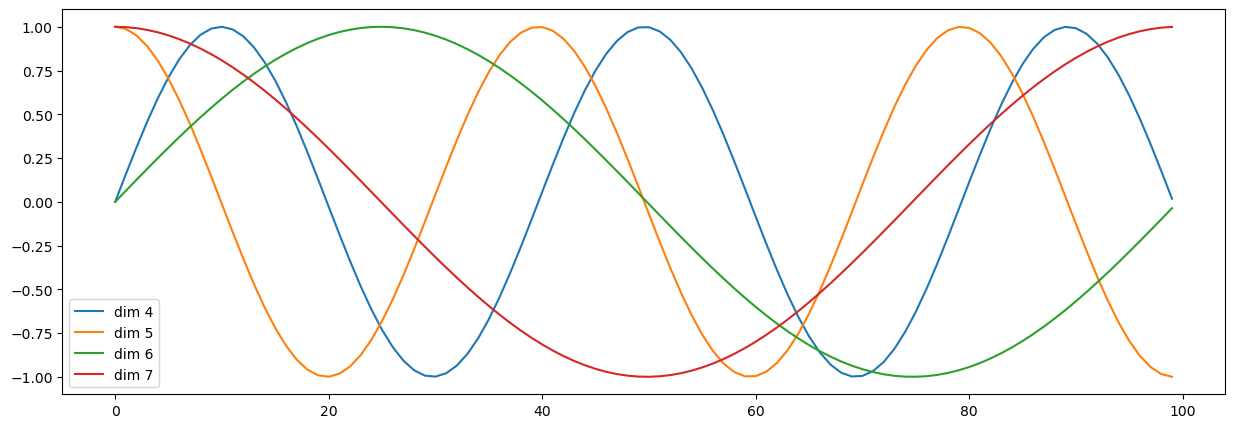

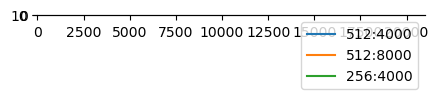

<Figure size 1200x800 with 0 Axes>

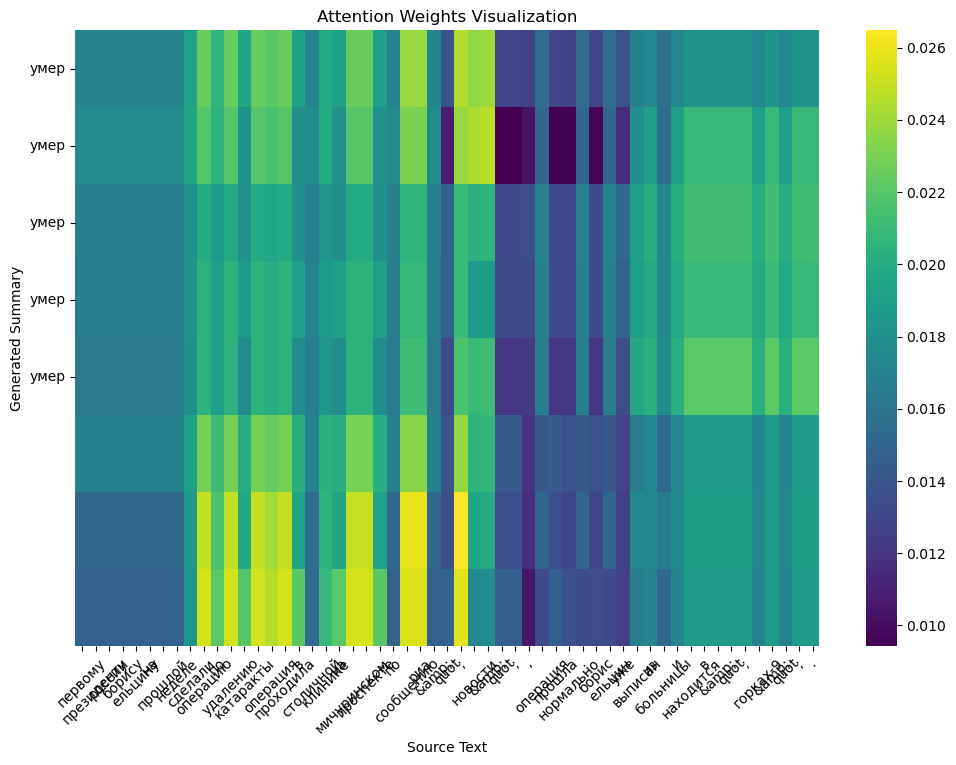


Example 2:
Source: девятая партия матча на первенство мира по шахматам между гарри каспаровым и владимиром крамником состоится в воскресенье . восьмая партия , прошедшая в субботу , завершилась вничью на 38-м ходу . впервые в матче чемпион мира сумел перехватить инициативу , играя черными . впервые в матче каспаров применил защиту нимцовича . примененная на 16-м ходу новинка позволила ему получить преимущество . крамник сделал несколько неточных ходов , и к 30-му ходу его соперник получил перспективный эндшпиль с лишней пешкой . к тому же владимир угодил в сильный цейнтнот . однако , чемпиону мира не удалось реализовать свое преимущество . партия завершилась вничью , и крамник выиграл первую половину матча со счетом 4 1 / 2 на 3 1 / 2 очка .
Target: крамник попал в цейтнот , но продолжает опережать каспарова
Generated: забил забил гол гол гол гол гол


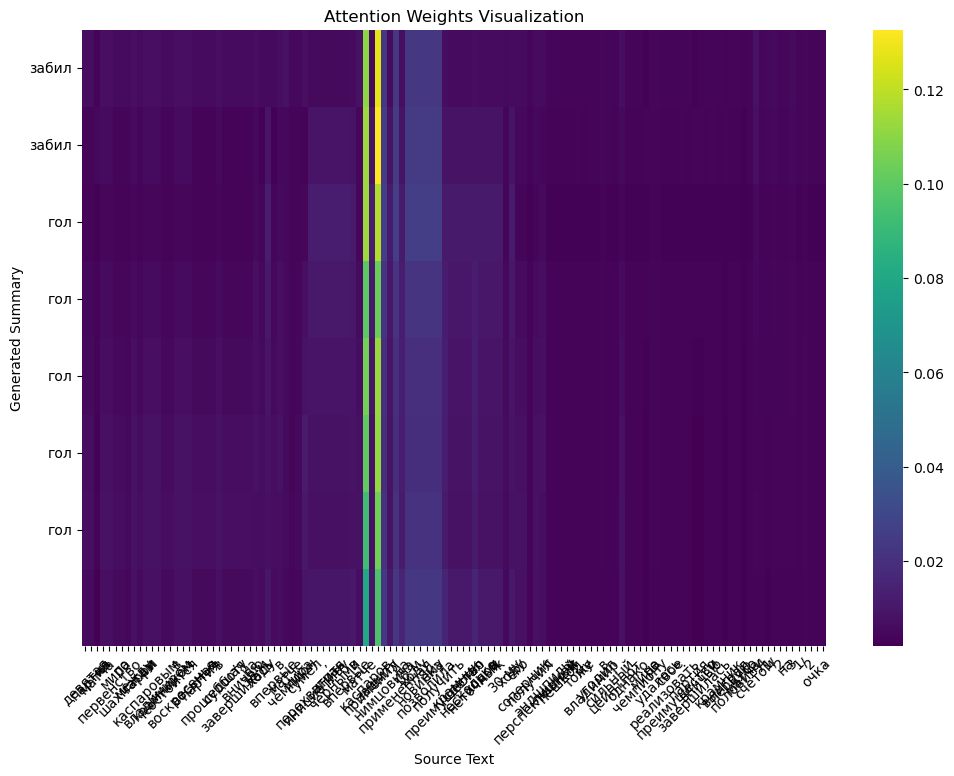


Example 3:
Source: в испании в результате взрыва мины-ловушки , установленной баскскими сепаратистами из группировки ета , погиб один полицейский , еще трое получили ранения , сообщает агентство associated press . по данным министерства внутренних дел испании , бомба была скрыта под плакатом с символом ета , установленном у обочины автотрассы в юго-восточной части страны басков . к месту обнаружения плаката прибыли две патрульные машины . взрыв произошел в тот момент , когда полицейские осматривали находку . пока никто не взял на себя ответственности за теракт , однако , по мнению спецслужб , символика ета - змея , обвивающая рукоять топора , не оставляет сомнения в авторстве . новый теракт совершен менее чем через сутки после взрыва в городе бильбао ( bilbao ) .
Target: мина-ловушка взорвалась в стране басков . погиб полицейский , трое ранены
Generated: москвы москвы москвы ранены ранены ранены ранены ранены


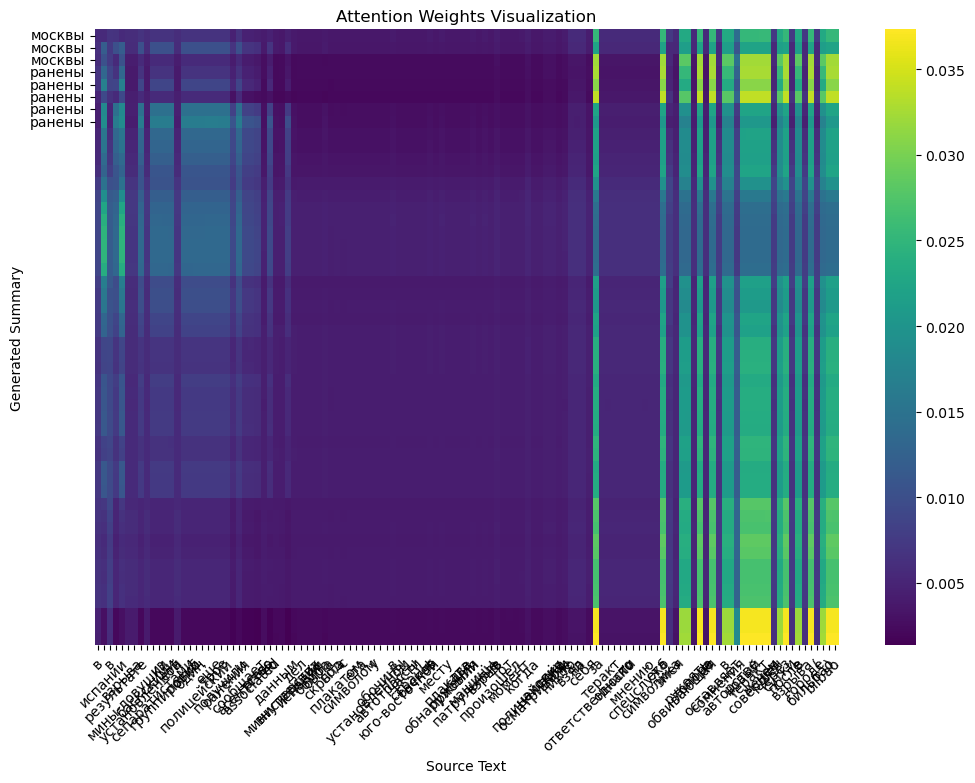


Example 4:
Source: бетономешалка упала с моста на поезд в британском городе оксшотт , сообщает sky news 5 ноября . четверо пассажиров поезда получили незначительные травмы . водитель бетономешалки пострадал более серьезно . в каком состоянии он находится , не уточняется . инцидент произошел в пятницу днем . по невыясненным пока причинам бетономешалка упала с моста на вагоны пассажирского поезда , следовавшего из гилфорда в лондон . в поезде на тот момент находились приблизительно сорок человек . несколько человек оказались заблокированы в поврежденных вагонах поезда . им на помощь приехали пожарные и полиция , а также шесть машин &quot; скорой помощи &quot; .
Target: в великобритании бетономешалка упала с моста на поезд
Generated: москвы москвы москвы ранены ранены ранены ранены ранены


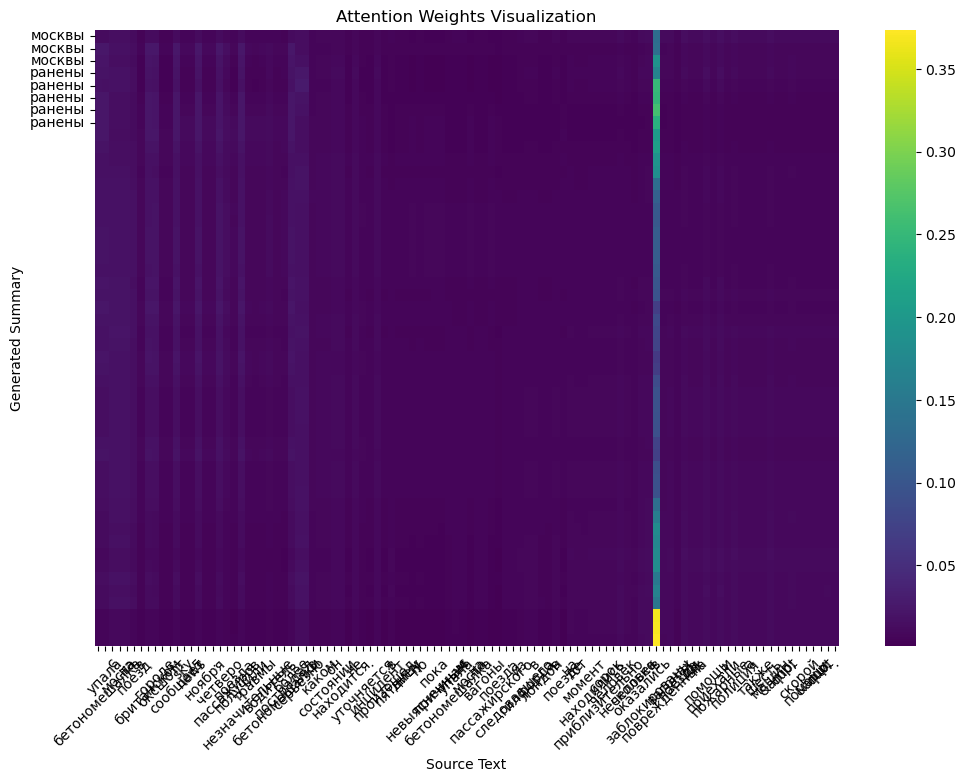


Example 5:
Source: комедия &quot; джуно &quot; , получившая четыре номинации на премию &quot; оскар &quot; , стала самым коммерчески успешным независимым фильмом последних шести лет в сша . об этом сообщает slashfilm . картина канадского режиссера джейсона рейтмана собрала в прокате 143,1 миллиона долларов при бюджете в 7,5 миллиона долларов . при этом картина продолжает прибавлять в копилку каждую неделю по шесть миллионов долларов . последним столь же успешным в коммерческом плане фильмом независимой киностудии была комедия &quot; моя большая греческая свадьба &quot; ( &quot; my big fat greek wedding &quot; ) режиссера джоэла цвика , которая вышла на экраны кинотеатров в 2002 году . этот фильм собрал в прокате в сша 241,4 миллиона долларов . &quot; джуно &quot; - история беременной девушки-подростка , которая решает отдать ребенка на усыновление .
Target: комедия &quot; джуно &quot; стала самым успешным независимым проектом последних 6 лет
Generated: альбом альбом &quot; альбом &quo

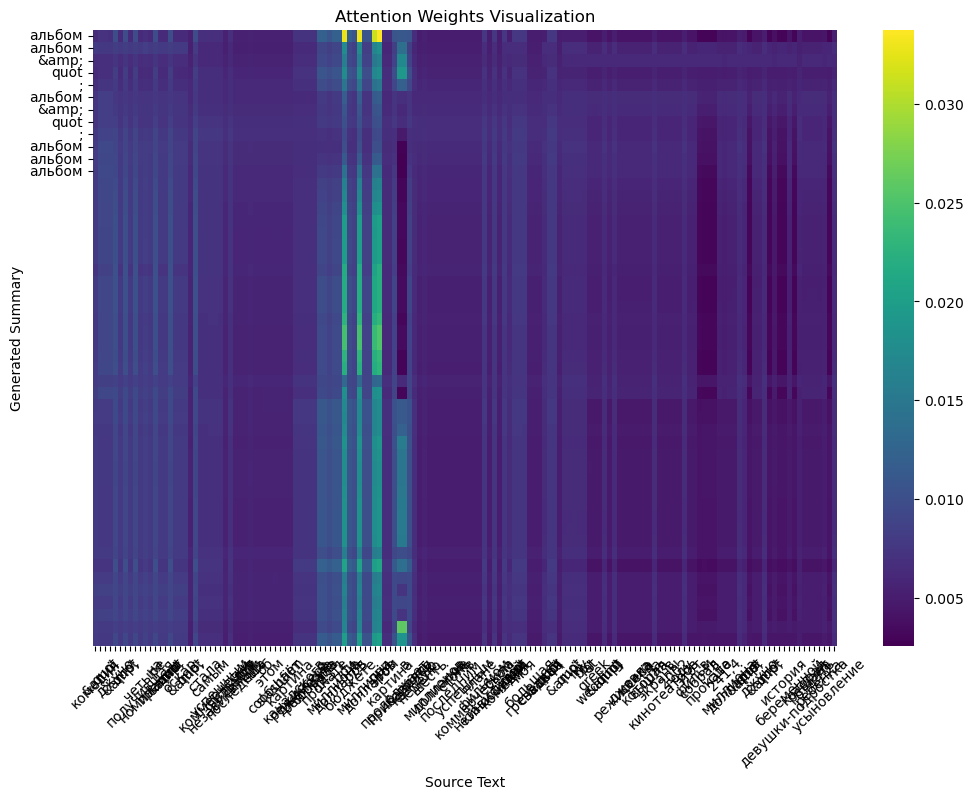


Custom Examples:

Custom Example 1:
Source: В результате масштабного исследования ученые обнаружили новый вид динозавров в Аргентине.
Generated: москвы москвы москвы года года ранены ранены


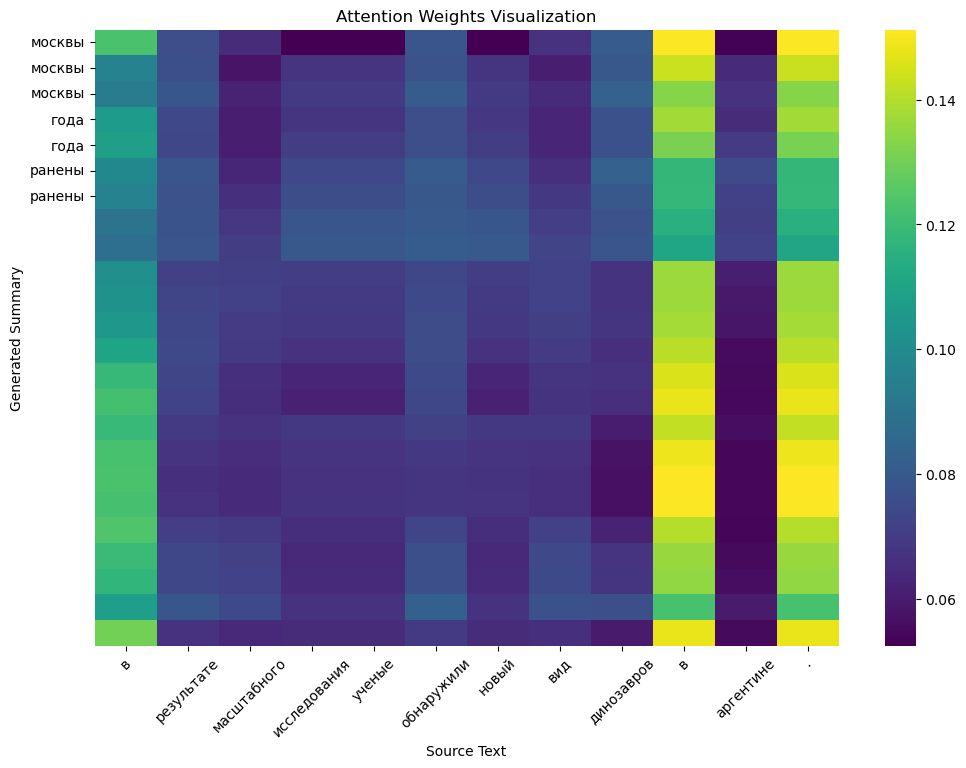


Custom Example 2:
Source: Компания SpaceX успешно запустила новую партию спутников Starlink на орбиту Земли.
Generated: москвы москвы москвы москвы москвы москвы москвы


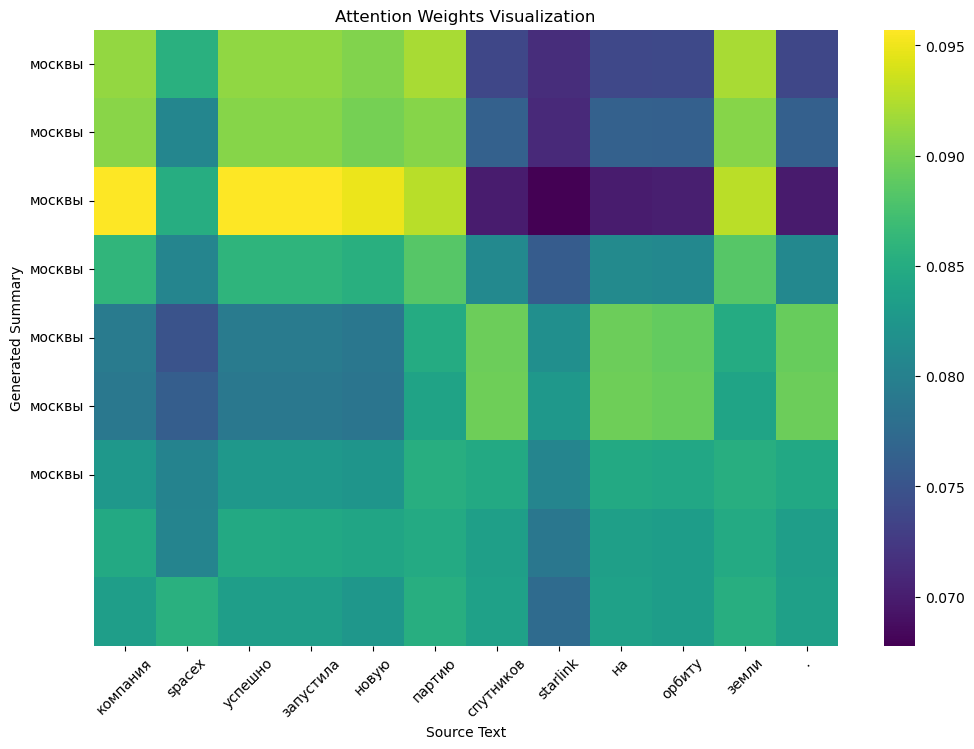


Custom Example 3:
Source: Исследователи разработали новый метод очистки океана от пластикового мусора.
Generated: москвы москвы москвы москвы москвы москвы москвы


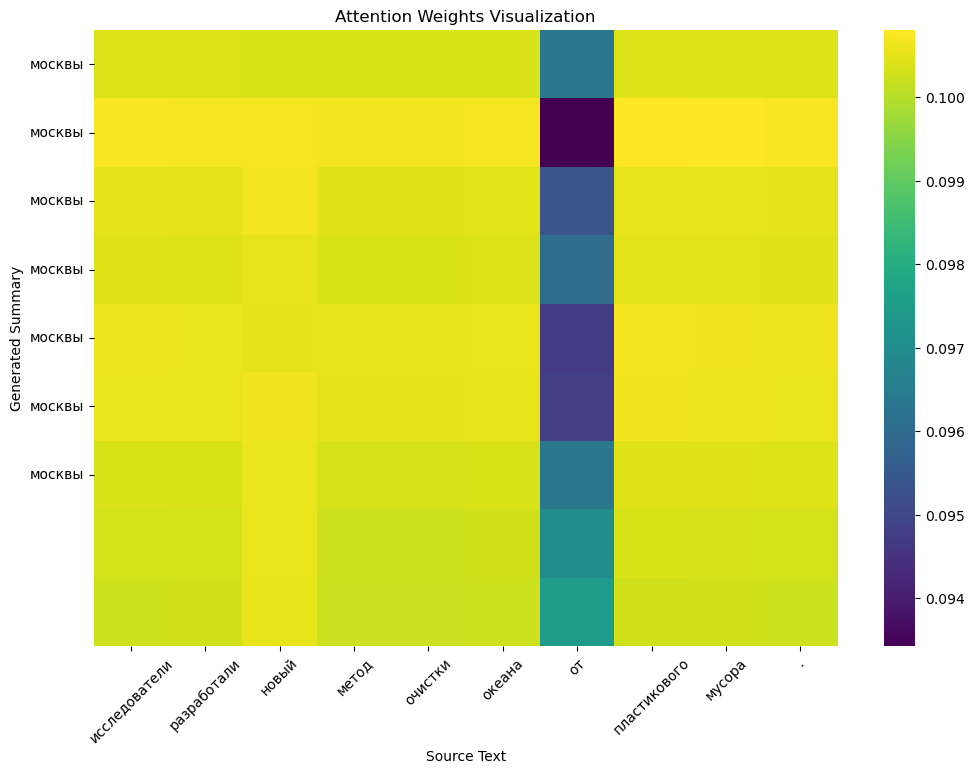


Custom Example 4:
Source: В центре Москвы открылась крупнейшая выставка современного искусства.
Generated: москвы москвы москвы москвы москвы москвы москвы


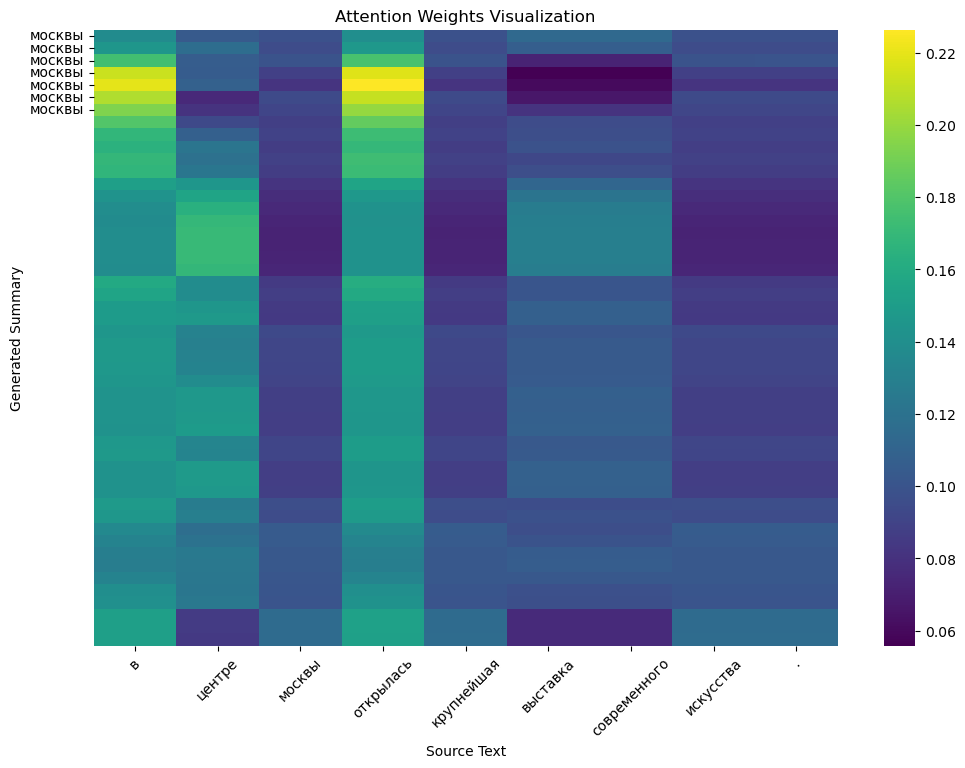


Custom Example 5:
Source: Ученые создали новый тип искусственного интеллекта.
Generated: москвы москвы москвы москвы москвы москвы москвы


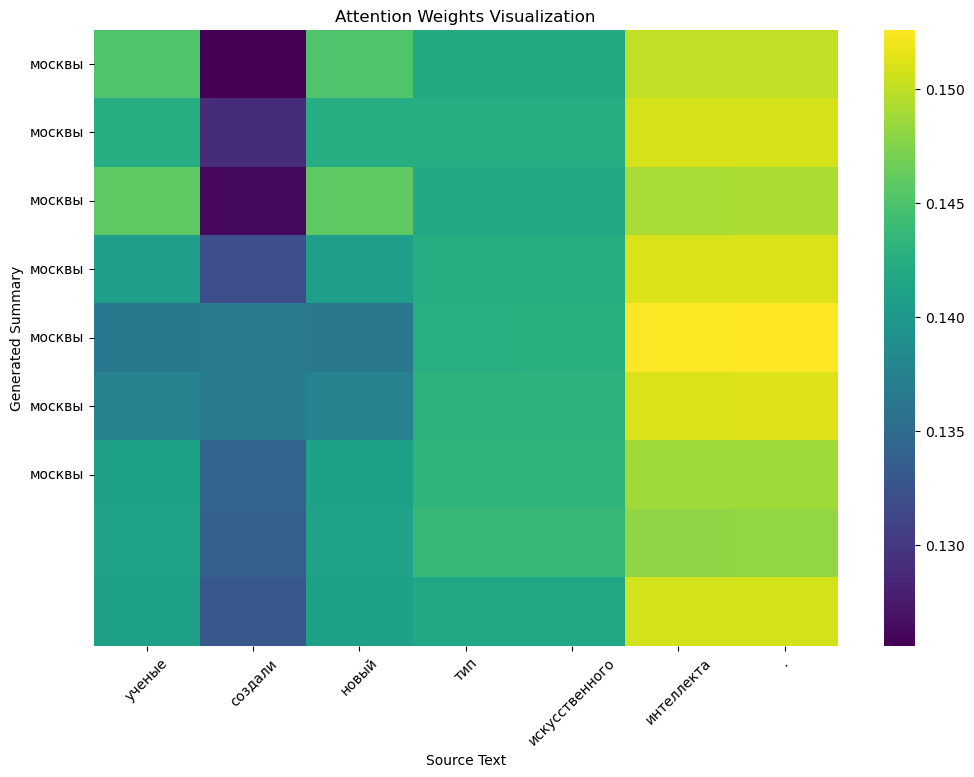

TypeError: cannot unpack non-iterable NoneType object

In [40]:
test_examples, custom_examples = evaluate_complete_model(model, test_dataset, word_field)

print("\nTraining completed! Check the following files for results:")
print("- logs/training_log.txt - Training progress")
print("- logs/training_history.png - Training loss plot")
print("- results/test_predictions.txt - Generated summaries")
print("- results/attention_*.png - Attention visualizations")

In [85]:
def generate_summary(model, text, word_field, max_len=50, beam_size=5, temperature=0.7):
    model.eval()
    if isinstance(text, list):
        text = ' '.join(text)
    
    tokens = word_field.preprocess(text)
    src = torch.tensor([
        word_field.vocab.stoi[t] if t in word_field.vocab.stoi 
        else word_field.vocab.stoi['<unk>'] 
        for t in tokens
    ], device=DEVICE).unsqueeze(0)
    
    src_mask = (src != word_field.vocab.stoi['<pad>']).unsqueeze(-2)
    
    beams = [([word_field.vocab.stoi['<s>']], 0)]
    
    for _ in range(max_len):
        new_beams = []
        for seq, score in beams:
            if seq[-1] == word_field.vocab.stoi['</s>']:
                new_beams.append((seq, score))
                continue
                
            tgt = torch.tensor(seq, device=DEVICE).unsqueeze(0)
            tgt_mask = subsequent_mask(tgt.size(1)).to(DEVICE)
            
            with torch.no_grad():
                out = model(src, tgt, src_mask, tgt_mask)
                logits = out[:, -1, :] / temperature
                probs = F.softmax(logits, dim=-1)
                
                # штрафуем повторяющиеся токены
                if len(seq) > 1:
                    for prev_token in seq[-3:]:  
                        probs[0, prev_token] *= 0.7 
            
            top_probs, top_indices = torch.topk(probs, beam_size)
            for i in range(beam_size):
                new_seq = seq + [top_indices[0, i].item()]
                new_score = score + torch.log(top_probs[0, i]).item()
                
                # нормализуем
                new_score = new_score / len(new_seq)**0.6
                
                new_beams.append((new_seq, new_score))
        
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
        
        if all(seq[-1] == word_field.vocab.stoi['</s>'] for seq, _ in beams):
            break
    
    best_seq = beams[0][0]
    return ' '.join([
        word_field.vocab.itos[i] 
        for i in best_seq[1:-1] 
        if i not in {word_field.vocab.stoi['<unk>'], word_field.vocab.stoi['<pad>']}
    ])

In [87]:
def evaluate_complete_model(model, test_dataset, word_field):
    os.makedirs('results', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    print("Calculating ROUGE metrics...")
    rouge_scores = evaluate_rouge_fast(model, test_dataset[:100], word_field)
    print("ROUGE Scores:", rouge_scores)
    
    test_examples = []
    custom_examples = []
    
    print("\nTest Examples:")
    for i, example in enumerate(test_dataset.examples[:5]):
        source_text = ' '.join(example.source)
        target_text = ' '.join([t for t in example.target if t not in ['<s>', '</s>', '<pad>']])
        generated = generate_summary(model, source_text, word_field)
        
        example_dict = {
            'source': source_text,
            'target': target_text,
            'generated': generated
        }
        test_examples.append(example_dict)
        
        print(f"\nExample {i+1}:")
        print(f"Source: {source_text}")
        print(f"Target: {target_text}")
        print(f"Generated: {generated}")
        
        visualize_attention(model, source_text, word_field, f'results/attention_test_{i+1}.png')
    
    custom_texts = [
        "В результате масштабного исследования ученые обнаружили новый вид динозавров в Аргентине.",
        "Компания SpaceX успешно запустила новую партию спутников Starlink на орбиту Земли.",
        "Исследователи разработали новый метод очистки океана от пластикового мусора.",
        "В центре Москвы открылась крупнейшая выставка современного искусства.",
        "Ученые создали новый тип искусственного интеллекта."
    ]
    
    print("\nCustom Examples:")
    for i, text in enumerate(custom_texts):
        generated = generate_summary(model, text, word_field)
        
        example_dict = {
            'source': text,
            'target': text.split('.')[0],
            'generated': generated
        }
        custom_examples.append(example_dict)
        
        print(f"\nCustom Example {i+1}:")
        print(f"Source: {text}")
        print(f"Generated: {generated}")
        
        visualize_attention(model, text, word_field, f'results/attention_custom_{i+1}.png')
    
    with open('results/test_predictions.txt', 'w', encoding='utf-8') as f:
        f.write("Test Examples:\n")
        for i, example in enumerate(test_examples):
            f.write(f"\nExample {i+1}:\n")
            f.write(f"Source: {example['source']}\n")
            f.write(f"Target: {example['target']}\n")
            f.write(f"Generated: {example['generated']}\n")
            f.write('-' * 80 + '\n')
        
        f.write("\nCustom Examples:\n")
        for i, example in enumerate(custom_examples):
            f.write(f"\nCustom Example {i+1}:\n")
            f.write(f"Source: {example['source']}\n")
            f.write(f"Generated: {example['generated']}\n")
            f.write('-' * 80 + '\n')
    

    torch.save({
        'model_state_dict': model.state_dict(),
        'word_field': word_field,
        'rouge_scores': rouge_scores
    }, 'results/transformer_summarizer.pt')
    
    return test_examples, custom_examples

Calculating ROUGE metrics...
Processed 10/100 examples
Processed 20/100 examples
Processed 30/100 examples
Processed 40/100 examples
Processed 50/100 examples
Processed 60/100 examples
Processed 70/100 examples
Processed 80/100 examples
Processed 90/100 examples
Processed 100/100 examples
ROUGE Scores: {'rouge1': 0.014666666666666668, 'rouge2': 0.011666666666666665, 'rougeL': 0.014666666666666668}

Test Examples:

Example 1:
Source: первому президенту россии борису ельцину на прошлой неделе сделали операцию по удалению катаракты . операция проходила в столичной клинике на мичуринском проспекте . по сообщению риа &quot; новости &quot; , операция прошла нормально . борис ельцин уже выписан из больницы и находится в &quot; горках-9 &quot; .
Target: борису ельцину сделали операцию по удалению катаракты
Generated: закрыли закрыли москвы &quot; закрыли работу работу


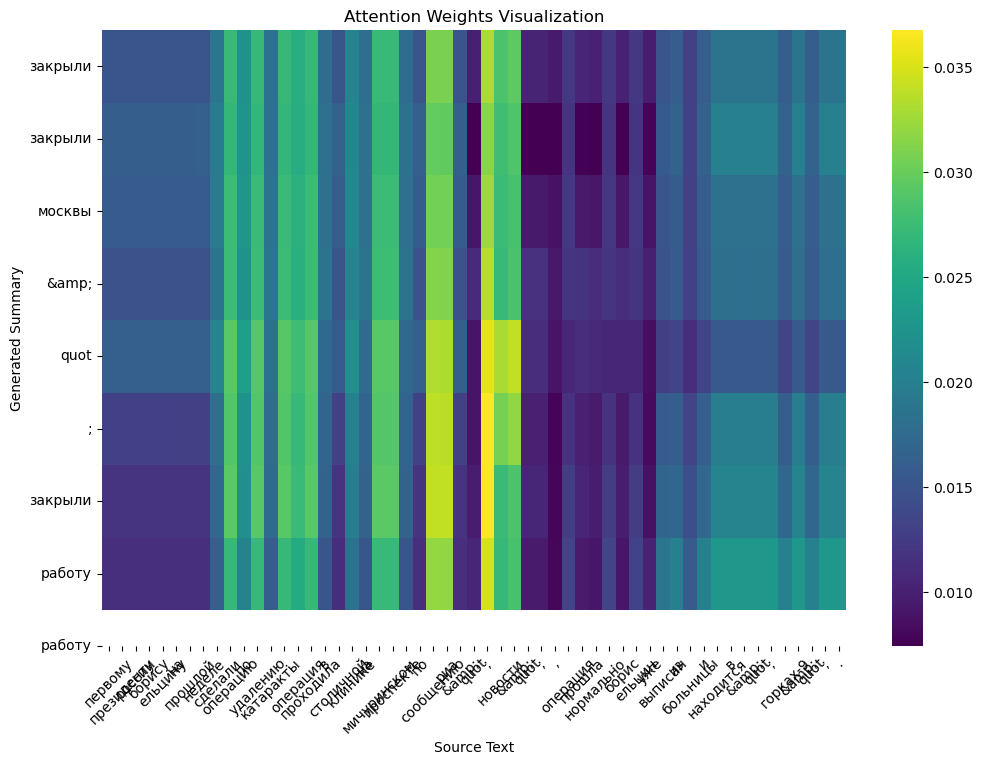


Example 2:
Source: девятая партия матча на первенство мира по шахматам между гарри каспаровым и владимиром крамником состоится в воскресенье . восьмая партия , прошедшая в субботу , завершилась вничью на 38-м ходу . впервые в матче чемпион мира сумел перехватить инициативу , играя черными . впервые в матче каспаров применил защиту нимцовича . примененная на 16-м ходу новинка позволила ему получить преимущество . крамник сделал несколько неточных ходов , и к 30-му ходу его соперник получил перспективный эндшпиль с лишней пешкой . к тому же владимир угодил в сильный цейнтнот . однако , чемпиону мира не удалось реализовать свое преимущество . партия завершилась вничью , и крамник выиграл первую половину матча со счетом 4 1 / 2 на 3 1 / 2 очка .
Target: крамник попал в цейтнот , но продолжает опережать каспарова
Generated: первый забил &quot; выиграл &quot; появилась &quot;


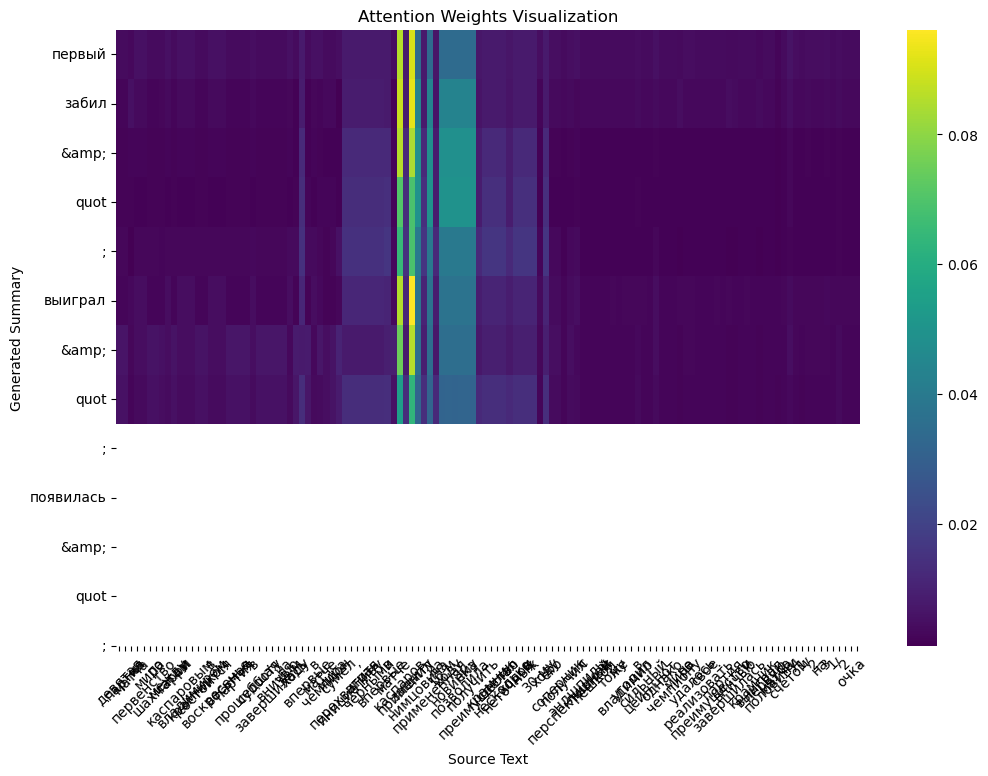


Example 3:
Source: в испании в результате взрыва мины-ловушки , установленной баскскими сепаратистами из группировки ета , погиб один полицейский , еще трое получили ранения , сообщает агентство associated press . по данным министерства внутренних дел испании , бомба была скрыта под плакатом с символом ета , установленном у обочины автотрассы в юго-восточной части страны басков . к месту обнаружения плаката прибыли две патрульные машины . взрыв произошел в тот момент , когда полицейские осматривали находку . пока никто не взял на себя ответственности за теракт , однако , по мнению спецслужб , символика ета - змея , обвивающая рукоять топора , не оставляет сомнения в авторстве . новый теракт совершен менее чем через сутки после взрыва в городе бильбао ( bilbao ) .
Target: мина-ловушка взорвалась в стране басков . погиб полицейский , трое ранены
Generated: в в в доме в жилом доме


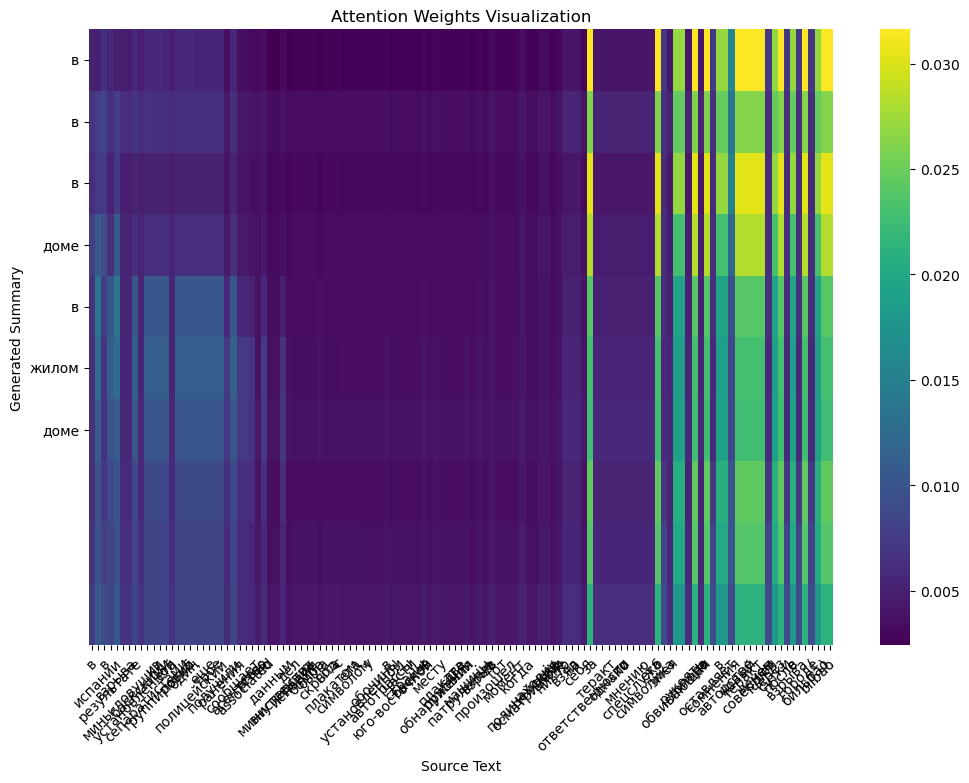


Example 4:
Source: бетономешалка упала с моста на поезд в британском городе оксшотт , сообщает sky news 5 ноября . четверо пассажиров поезда получили незначительные травмы . водитель бетономешалки пострадал более серьезно . в каком состоянии он находится , не уточняется . инцидент произошел в пятницу днем . по невыясненным пока причинам бетономешалка упала с моста на вагоны пассажирского поезда , следовавшего из гилфорда в лондон . в поезде на тот момент находились приблизительно сорок человек . несколько человек оказались заблокированы в поврежденных вагонах поезда . им на помощь приехали пожарные и полиция , а также шесть машин &quot; скорой помощи &quot; .
Target: в великобритании бетономешалка упала с моста на поезд
Generated: пожара пожара погибли погибли пострадали пострадали пострадали пострадали пострадали пострадали пострадали пострадали пострадали пострадали пострадали — пострадали пострадали пострадали : ранены : ранены ранены ранены пострадали ранены : ранены ранены : ране

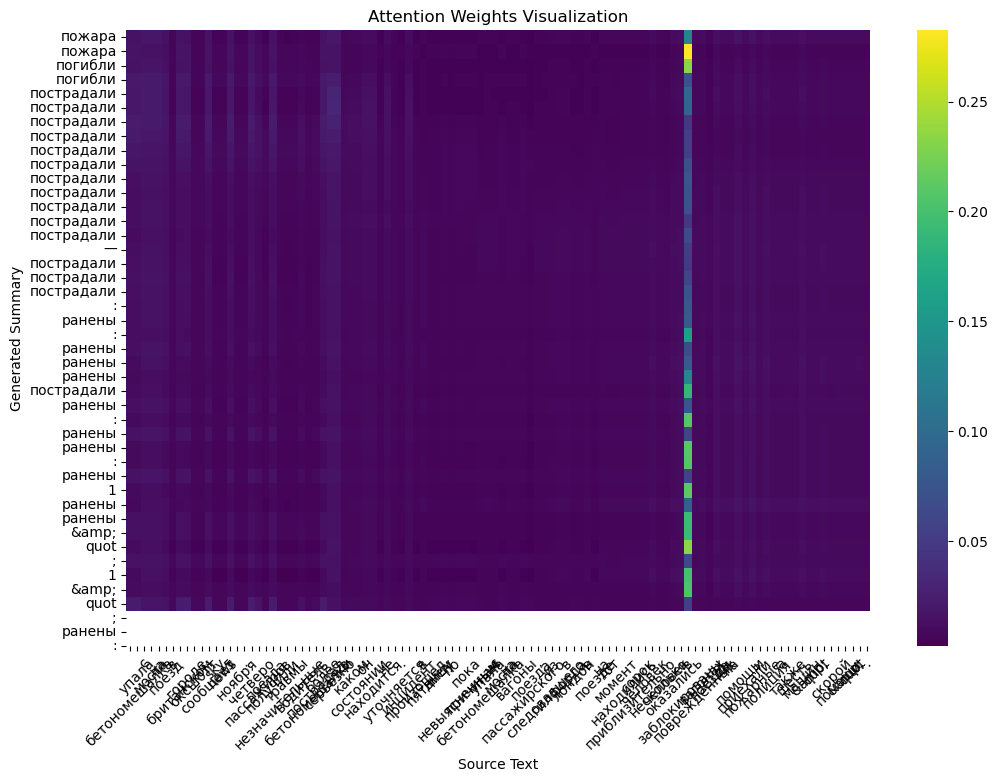


Example 5:
Source: комедия &quot; джуно &quot; , получившая четыре номинации на премию &quot; оскар &quot; , стала самым коммерчески успешным независимым фильмом последних шести лет в сша . об этом сообщает slashfilm . картина канадского режиссера джейсона рейтмана собрала в прокате 143,1 миллиона долларов при бюджете в 7,5 миллиона долларов . при этом картина продолжает прибавлять в копилку каждую неделю по шесть миллионов долларов . последним столь же успешным в коммерческом плане фильмом независимой киностудии была комедия &quot; моя большая греческая свадьба &quot; ( &quot; my big fat greek wedding &quot; ) режиссера джоэла цвика , которая вышла на экраны кинотеатров в 2002 году . этот фильм собрал в прокате в сша 241,4 миллиона долларов . &quot; джуно &quot; - история беременной девушки-подростка , которая решает отдать ребенка на усыновление .
Target: комедия &quot; джуно &quot; стала самым успешным независимым проектом последних 6 лет
Generated: москвы москвы москвы года подряд

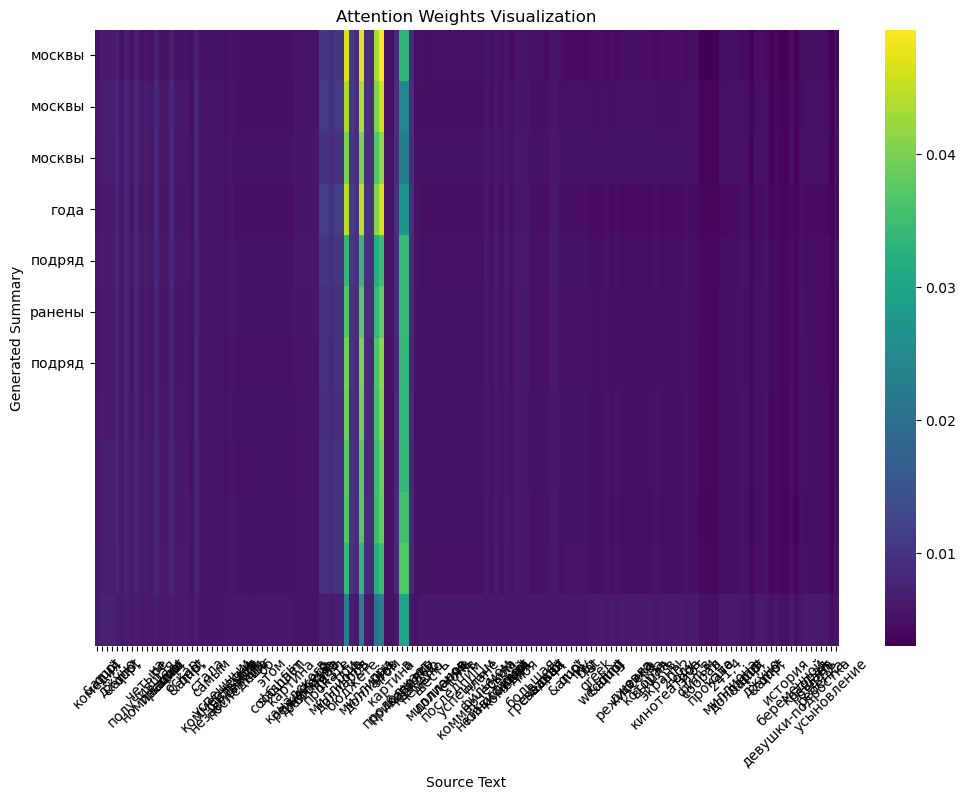


Custom Examples:

Custom Example 1:
Source: В результате масштабного исследования ученые обнаружили новый вид динозавров в Аргентине.
Generated: москвы москвы москвы года года ранены ранены


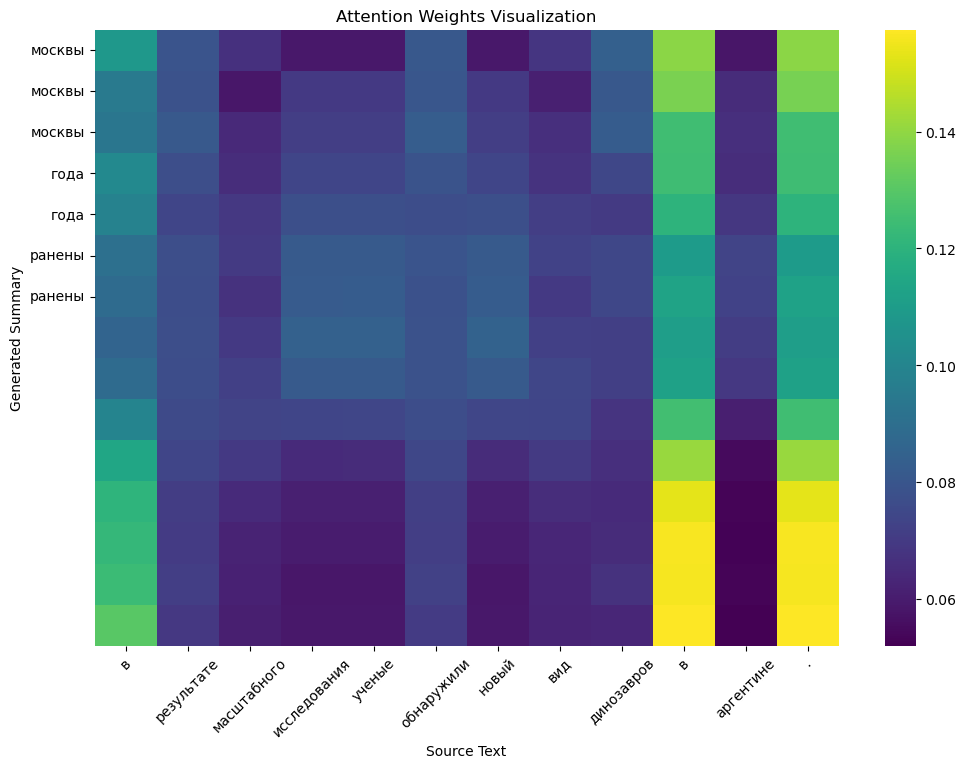


Custom Example 2:
Source: Компания SpaceX успешно запустила новую партию спутников Starlink на орбиту Земли.
Generated: москвы москвы москвы года года ранены ранены


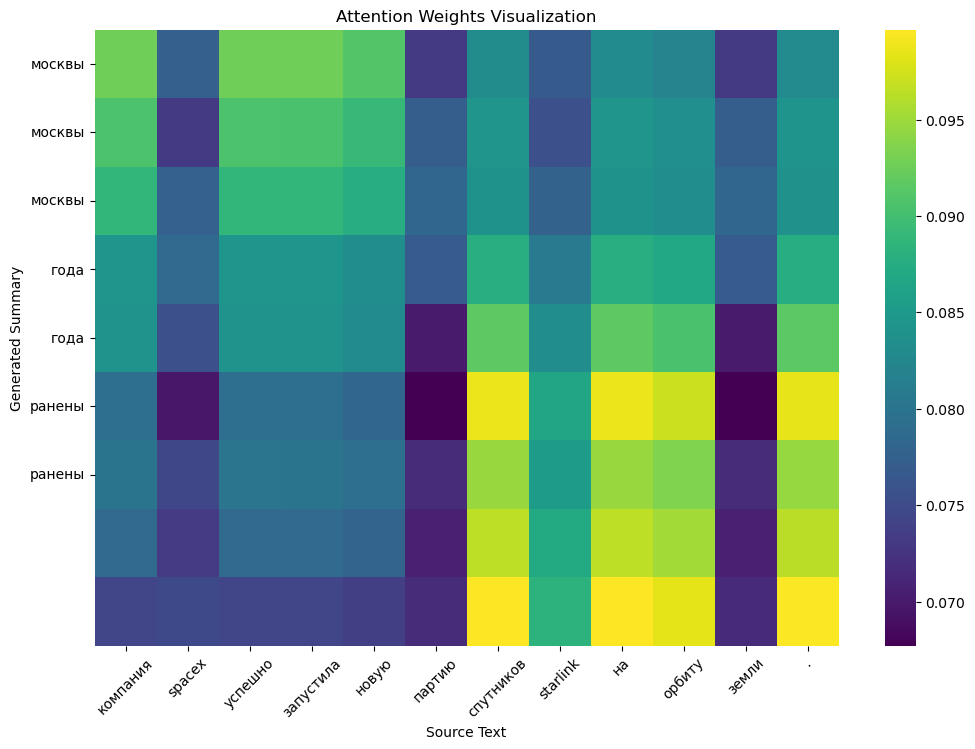


Custom Example 3:
Source: Исследователи разработали новый метод очистки океана от пластикового мусора.
Generated: неделю москвы москвы раз раз подряд ранены ранены


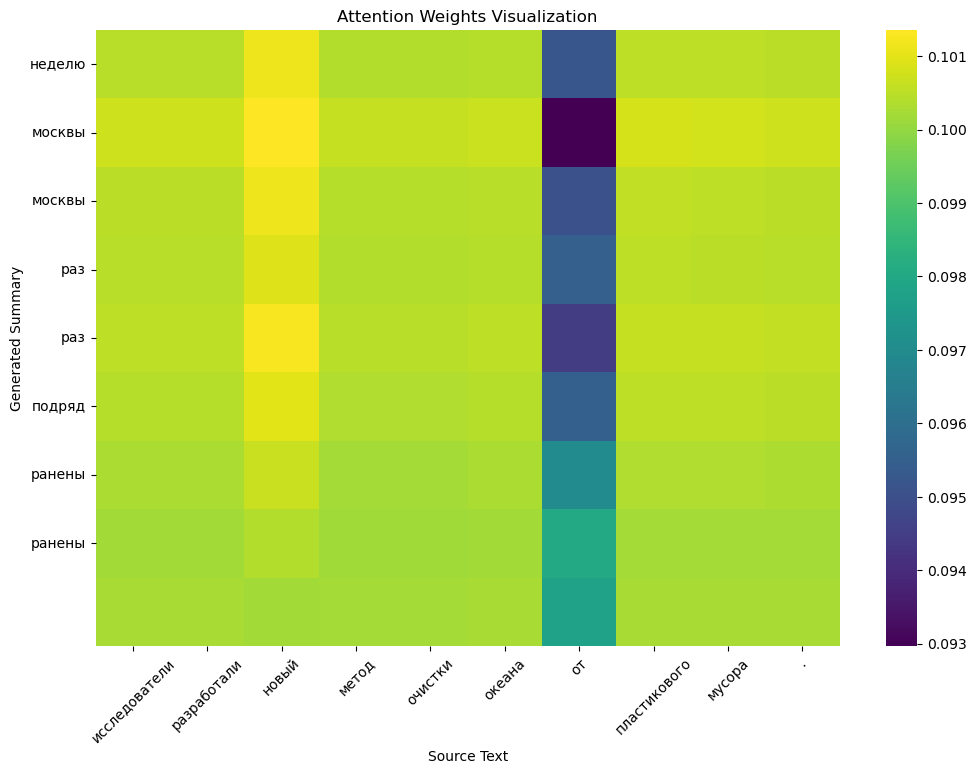


Custom Example 4:
Source: В центре Москвы открылась крупнейшая выставка современного искусства.
Generated: в в в доме в жилом доме


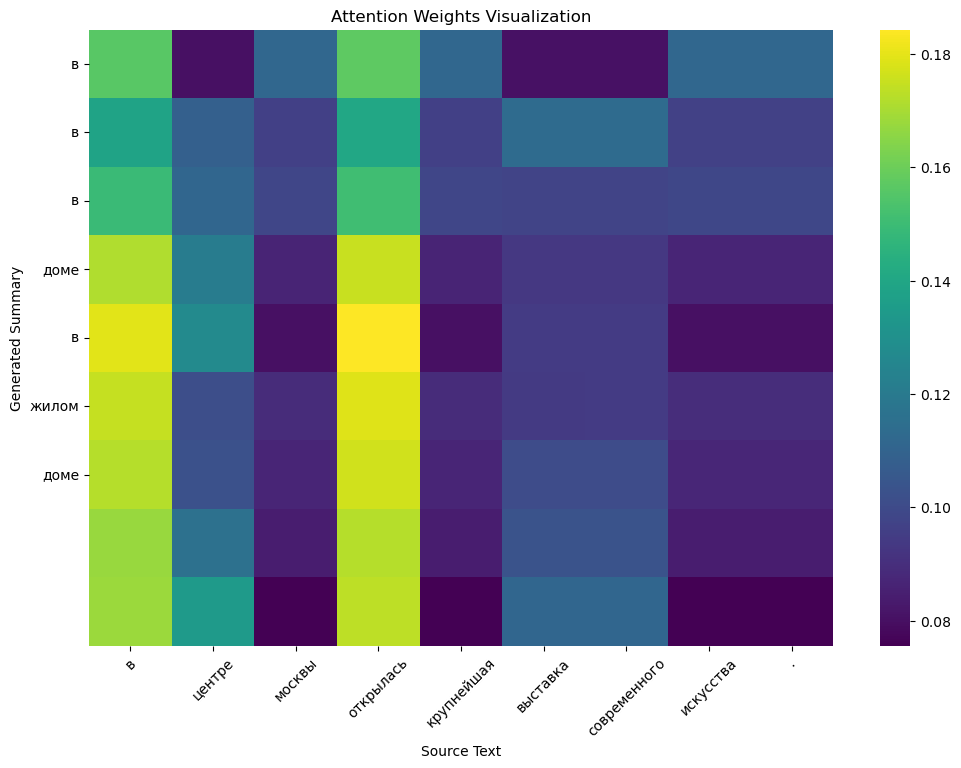


Custom Example 5:
Source: Ученые создали новый тип искусственного интеллекта.
Generated: альбом альбом &quot; &quot; &quot; умер &quot; альбом &quot;


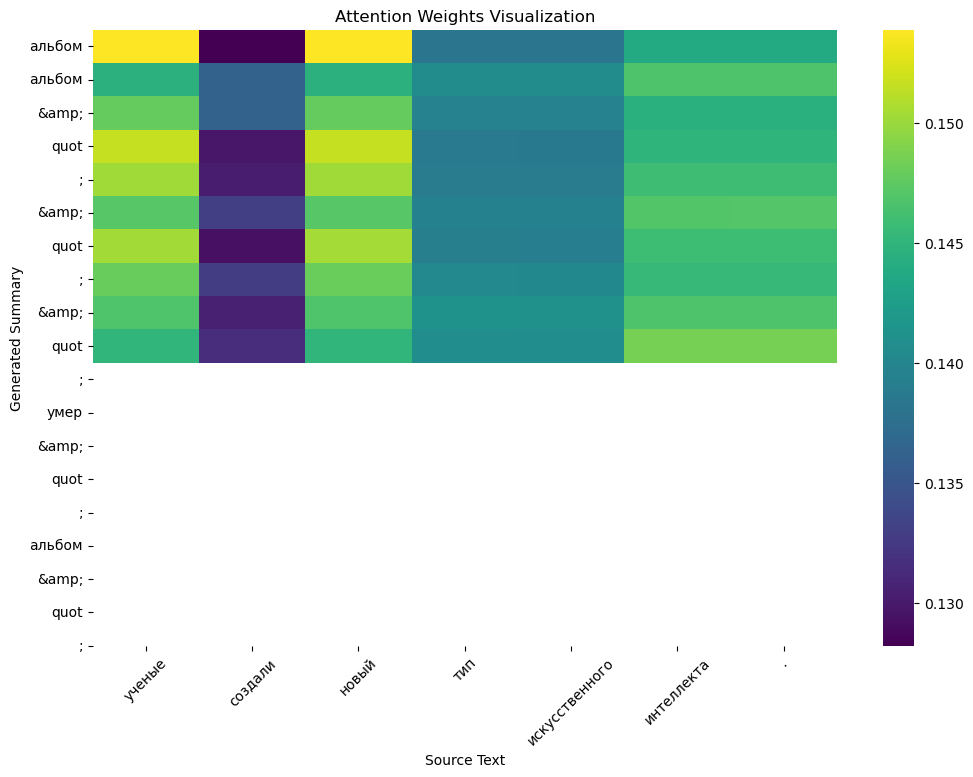


Training completed! Check the following files for results:
- results/test_predictions.txt - Generated summaries
- results/attention_*.png - Attention visualizations
- results/transformer_summarizer.pt - Model weights


In [54]:
# запуск evaluation2popitka
test_examples, custom_examples = evaluate_complete_model(model, test_dataset, word_field)

print("\nTraining completed! Check the following files for results:")
print("- results/test_predictions.txt - Generated summaries")
print("- results/attention_*.png - Attention visualizations")
print("- results/transformer_summarizer.pt - Model weights")

In [ ]:
model = train_model()

In [ ]:
os.makedirs('checkpointsLS', exist_ok=True)

print("\nTest set examplesLS:")
test_examples = demonstrate_summarization_examples(model, test_dataset, word_field)
for i, example in enumerate(test_examples, 1):
    print(f"\nExample {i}:")
    print(f"Source: {example['source']}")
    print(f"Target: {example['target']}")
    print(f"Generated: {example['generated']}")

print("\nCustom examplesLS:")
custom_dataset = Dataset(add_custom_examples_to_dataset(custom_examples, word_field), fields)
custom_examples = demonstrate_summarization_examples(model, custom_dataset, word_field)
for i, example in enumerate(custom_examples, 1):
    print(f"\nExample {i}:")
    print(f"Source: {example['source']}")
    print(f"Target: {example['target']}")
    print(f"Generated: {example['generated']}")

with open('test_predictionsLS.txt', 'w', encoding='utf-8') as f:
    for example in test_examples + custom_examples:
        f.write(f"Source: {example['source']}\n")
        f.write(f"Target: {example['target']}\n")
        f.write(f"Generated: {example['generated']}\n")
        f.write('-' * 100 + '\n')
